## Training for Athena rapgap MC with reconstructed observables as input.
### This version trains a classification network to attempt to identify events with ISR or FSR which is then fed into the regression network.


In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir


import uproot3

import matplotlib as mpl

from datetime import datetime
import subprocess


In [2]:
#has_gpu = False

has_gpu = True

training_name = 'training_athena_classification_v2a'




#--- Hyperparameter settings.

#max_events =   120000
#max_events =   600000
#max_events =  3000000
#max_events = 15000000
max_events = 1e9


learning_rate_setval = 1e-4
batch_size_setval = 128
max_epochs = 5000
dropout_setval = 0.0


#input_file = 'athena-rapgap-delphes/dnn-inputs-v2-2m.root'
input_file = 'athena-rapgap-delphes/dnn-inputs-v3-12m.root'
#input_file = 'athena-rapgap-delphes/dnn-inputs-v2-28m.root'

parfile = open( '%s-setup.txt' % training_name,'w')

parfile.write('%s\n' % datetime.now() )
parfile.write('training_name : %s\n' % training_name )
parfile.write('input_file : %s\n' % input_file )
parfile.write('max_events : %d\n' % max_events )
parfile.write('learning_rate_setval : %g\n' % learning_rate_setval )
parfile.write('batch_size_setval : %d\n' % batch_size_setval )
parfile.write('max_epochs : %d\n' % max_epochs )
parfile.write('dropout_setval : %g\n' % dropout_setval )

parfile.close()

print('\n\n--- Training parameters file: %s-setup.txt\n' % training_name )
print( subprocess.getoutput('cat %s-setup.txt' % training_name ) )
print('\n\n')
    




--- Training parameters file: training_athena_classification_v2a-setup.txt

2021-09-18 11:49:43.653263
training_name : training_athena_classification_v2a
input_file : athena-rapgap-delphes/dnn-inputs-v3-12m.root
max_events : 1000000000
learning_rate_setval : 0.0001
batch_size_setval : 128
max_epochs : 5000
dropout_setval : 0





In [3]:
%%time


ur_file = uproot3.open(input_file)

print (ur_file.keys()) 
ur_tree = ur_file['minitree']
print(ur_tree)
ur_tree.show()


#pandas_df   =  ur_tree.pandas.df(['*'], entrystop=max_events,flatten=True)

pandas_df   =  ur_tree.pandas.df(
    ['has_isr','has_fsr',
     'tower_sum_40','n_towers_40', ''
     'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'phi_pho_closest_to_ebeam',
     'obs_x', 'obs_y', 'obs_Q2',
     'from_tlv_gen_Q2','from_tlv_gen_x','from_tlv_gen_y',
     'obs_e_e','obs_e_pz','obs_e_pt','obs_e_phi',
     'obs_hfs_e','obs_hfs_pz','obs_hfs_pt','obs_hfs_phi',
     'obs_dphi',
    ],
    entrystop=max_events,flatten=True)

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df.shape[0] )

[b'minitree;99', b'minitree;98']
<TTree b'minitree' at 0x7fb4b2779a60>
tower_sum_07               (no streamer)              asdtype('>f4')
tower_sum_20               (no streamer)              asdtype('>f4')
tower_sum_30               (no streamer)              asdtype('>f4')
tower_sum_40               (no streamer)              asdtype('>f4')
n_towers_07                (no streamer)              asdtype('>i4')
n_towers_20                (no streamer)              asdtype('>i4')
n_towers_30                (no streamer)              asdtype('>i4')
n_towers_40                (no streamer)              asdtype('>i4')
phi_pho_closest_to_ebeam   (no streamer)              asdtype('>f4')
eta_pho_closest_to_ebeam   (no streamer)              asdtype('>f4')
e_pho_closest_to_ebeam     (no streamer)              asdtype('>f4')
beam_e_e                   (no streamer)              asdtype('>f4')
beam_p_e                   (no streamer)              asdtype('>f4')
gen_y                      (no s

In [4]:
pandas_df

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_x[0],obs_x[1],obs_x[2],...,from_tlv_gen_y,obs_e_e,obs_e_pz,obs_e_pt,obs_e_phi,obs_hfs_e,obs_hfs_pz,obs_hfs_pt,obs_hfs_phi,obs_dphi
entry,,,,,,,,,,,,,,,,,,,,,
0,0,0,26.869205,1,1.095559,0.218338,-2.666086,0.200293,0.131117,0.064506,...,0.251049,27.020027,-0.222849,27.019108,2.803472,65.512703,47.529785,26.741028,-0.269342,3.072814
1,0,1,7.673062,1,-0.806565,0.123900,0.873671,0.019522,0.027737,0.000025,...,0.813027,7.630572,1.183487,7.538235,1.285149,30.146868,-5.843025,11.357022,-1.938380,3.223528
2,0,0,19.573723,1,2.218136,1.277983,0.068092,0.136569,0.152468,0.171497,...,0.115080,20.461201,-11.008204,17.247614,1.496734,60.996117,57.293331,16.069700,-1.686409,3.183143
3,0,0,19.095366,1,-0.280193,0.246890,3.083019,0.077725,0.078150,0.081713,...,0.321256,19.092752,-5.249075,18.357025,0.788046,43.237377,31.970116,20.053905,-2.375955,3.164001
4,0,1,12.676383,2,0.224588,0.293847,2.740003,0.036997,0.036044,0.040072,...,0.608685,13.327799,-1.179014,13.273133,-1.503182,24.069021,3.272655,11.200433,1.535005,3.244998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11772215,0,1,20.196772,2,0.643742,0.143994,-2.422676,0.083256,0.085965,0.100202,...,0.225946,19.234680,-7.685722,17.632431,-0.005903,41.592400,33.712208,17.412682,-3.129472,3.123569
11772216,0,1,17.626665,2,-0.115328,0.112558,-1.558644,0.072875,0.073566,0.081258,...,0.181016,18.388723,-10.753432,14.916731,2.056409,61.303341,55.029739,14.820149,-1.165214,3.221623
11772217,0,0,19.117268,1,0.064928,0.223935,2.596252,0.088563,0.083300,0.058592,...,0.329359,20.077959,-4.150744,19.644230,2.040797,45.171829,29.928778,25.913372,-1.098421,3.139219


In [5]:
pandas_df.eval( 'obs_hfs_Empz = obs_hfs_e - obs_hfs_pz', inplace=True )
pandas_df.eval( 'obs_e_Empz = obs_e_e - obs_e_pz', inplace=True )

pandas_df.eval( 'obs_event_Empz = obs_hfs_Empz + obs_e_Empz', inplace=True )

pandas_df.eval( 'rot_pt1 = 0.70710678 * obs_hfs_pt - 0.70710678 * obs_e_pt', inplace=True )
pandas_df.eval( 'rot_pt2 = 0.70710678 * obs_hfs_pt + 0.70710678 * obs_e_pt', inplace=True )

pandas_df.eval( 'rot_Empz1 = 0.70710678 * obs_hfs_Empz - 0.70710678 * obs_e_Empz', inplace=True )
pandas_df.eval( 'rot_Empz2 = 0.70710678 * obs_hfs_Empz + 0.70710678 * obs_e_Empz', inplace=True )

pandas_df.eval( 'gen_log_x = log(from_tlv_gen_x)', inplace=True )
pandas_df.eval( 'gen_log_y = log(from_tlv_gen_y)', inplace=True )
pandas_df.eval( 'gen_log_Q2 = log(from_tlv_gen_Q2)', inplace=True )

pandas_df.eval( 'e_ecal_over_trk_ratio = tower_sum_40/obs_e_e', inplace=True )
pandas_df.eval( 'e_ecal_over_trk_ratio = (e_ecal_over_trk_ratio<4)*e_ecal_over_trk_ratio + (e_ecal_over_trk_ratio>4)*4', inplace=True )

pandas_df.eval( 'dphi_pho_closest_to_ebeam = obs_e_phi - phi_pho_closest_to_ebeam', inplace=True )
pandas_df.eval( 'dphi_pho_closest_to_ebeam = (abs(dphi_pho_closest_to_ebeam)<3.14159265)*(dphi_pho_closest_to_ebeam)+(dphi_pho_closest_to_ebeam>3.14159265)*(dphi_pho_closest_to_ebeam-2*3.14159265) + (dphi_pho_closest_to_ebeam<-3.14159265)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df.eval( 'dphi_pho_closest_to_ebeam = (dphi_pho_closest_to_ebeam>0)*dphi_pho_closest_to_ebeam + (dphi_pho_closest_to_ebeam<0)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df.eval( 'dphi_pho_closest_to_ebeam = (phi_pho_closest_to_ebeam!=0)*(dphi_pho_closest_to_ebeam)+(phi_pho_closest_to_ebeam==0)*(-1)', inplace=True )

pandas_df.eval( 'e_pho_closest_to_ebeam = (e_pho_closest_to_ebeam<30)*e_pho_closest_to_ebeam + (e_pho_closest_to_ebeam>30)*30', inplace=True )

pandas_df.eval( 'n_towers_40 = (n_towers_40<7)*n_towers_40 + (n_towers_40>=7)*7', inplace=True  )

pandas_df.eval( 'has_norad = (has_isr==0) and (has_fsr==0)', inplace=True )

In [6]:
pandas_df

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_x[0],obs_x[1],obs_x[2],...,rot_pt1,rot_pt2,rot_Empz1,rot_Empz2,gen_log_x,gen_log_y,gen_log_Q2,e_ecal_over_trk_ratio,dphi_pho_closest_to_ebeam,has_norad
entry,,,,,,,,,,,,,,,,,,,,,
0,0,0,26.869205,1,1.095559,0.218338,-2.666086,0.200293,0.131117,0.064506,...,-0.196632,38.014156,-6.547779,31.979465,-1.649866,-1.382109,6.861462,0.994418,5.469558,True
1,0,1,7.673062,1,-0.806565,0.123900,0.873671,0.019522,0.027737,0.000025,...,2.700291,13.360964,20.889919,30.007473,-3.727254,-0.206991,5.959193,1.005569,0.411477,False
2,0,0,19.573723,1,2.218136,1.277983,0.068092,0.136569,0.152468,0.171497,...,-0.832911,23.558899,-19.633965,24.870495,-1.889213,-2.162132,5.842093,0.956626,1.428642,True
3,0,0,19.095366,1,-0.280193,0.246890,3.083019,0.077725,0.078150,0.081713,...,1.199875,27.160629,-9.245113,25.179428,-2.542774,-1.135516,6.215146,1.000137,3.988212,True
4,0,1,12.676383,2,0.224588,0.293847,2.740003,0.036997,0.036044,0.040072,...,-1.465621,17.305424,4.447387,24.963120,-3.321063,-0.496454,6.075917,0.951124,2.040000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11772215,0,1,20.196772,2,0.643742,0.143994,-2.422676,0.083256,0.085965,0.100202,...,-0.155386,24.780636,-13.463462,24.607735,-2.341344,-1.487459,6.064631,1.050019,2.416773,False
11772216,0,1,17.626665,2,-0.115328,0.112558,-1.558644,0.072875,0.073566,0.081258,...,-0.068293,21.027149,-16.170509,25.042721,-2.556332,-1.709168,5.627935,0.958558,3.615053,False
11772217,0,0,19.117268,1,0.064928,0.223935,2.596252,0.088563,0.083300,0.058592,...,4.432953,32.214088,-6.353815,27.910746,-2.434827,-1.110608,6.348000,0.952152,5.727731,True


## Apply any event selection here.

In [7]:
pandas_df = pandas_df.query('obs_event_Empz > 32 and obs_event_Empz < 40')

pandas_df = pandas_df.query('from_tlv_gen_Q2 > 200')

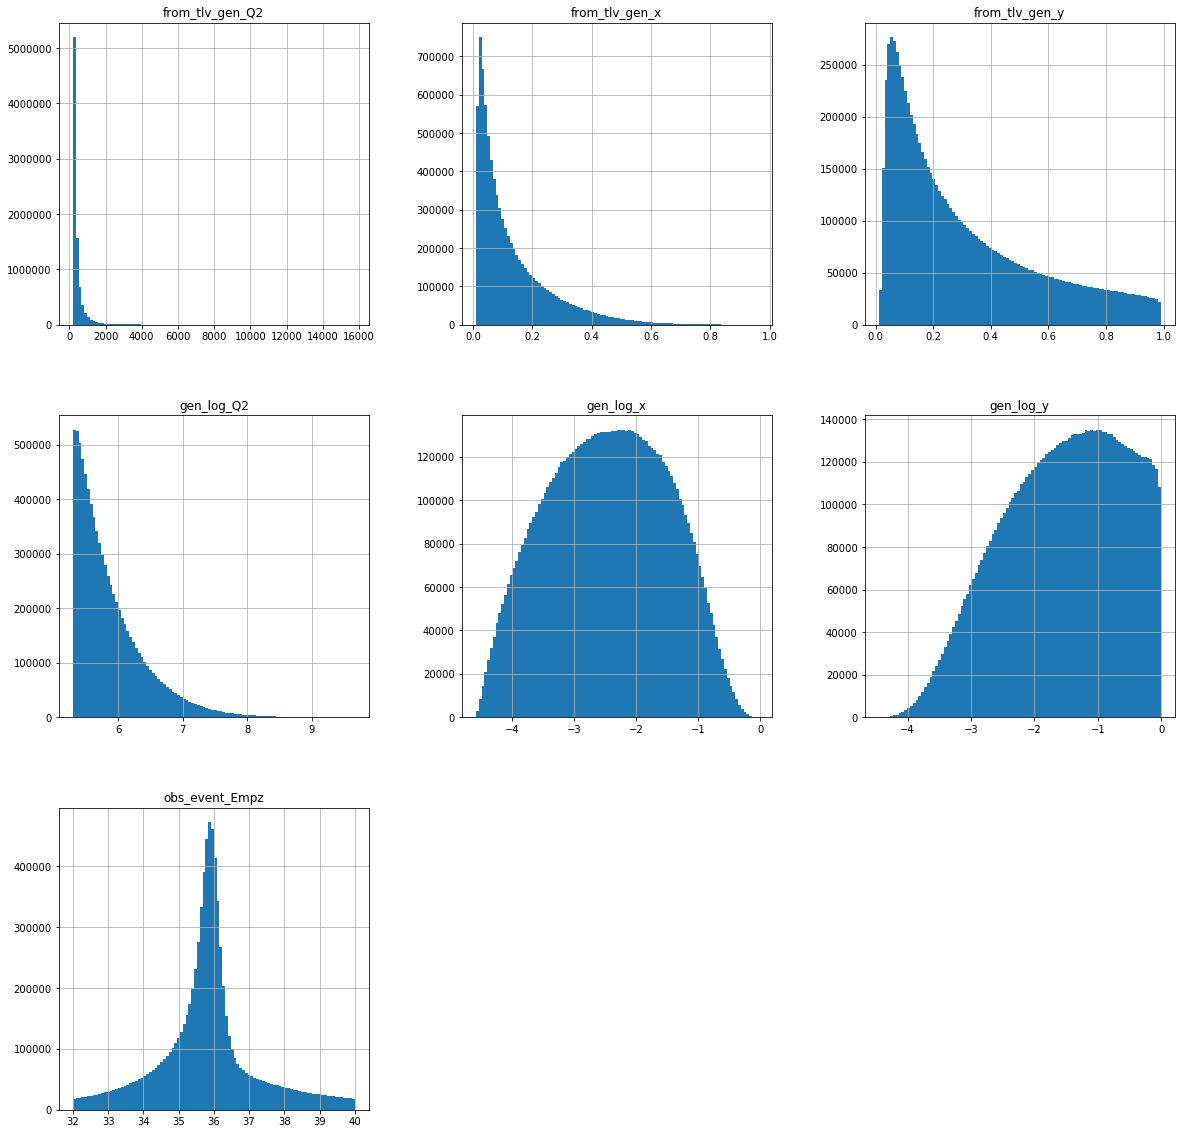

In [8]:
pandas_df.hist( figsize=(20,20), bins=100, column=['from_tlv_gen_x','from_tlv_gen_y','from_tlv_gen_Q2',
                        'gen_log_x','gen_log_y','gen_log_Q2','obs_event_Empz',
                        ])
plt.show()

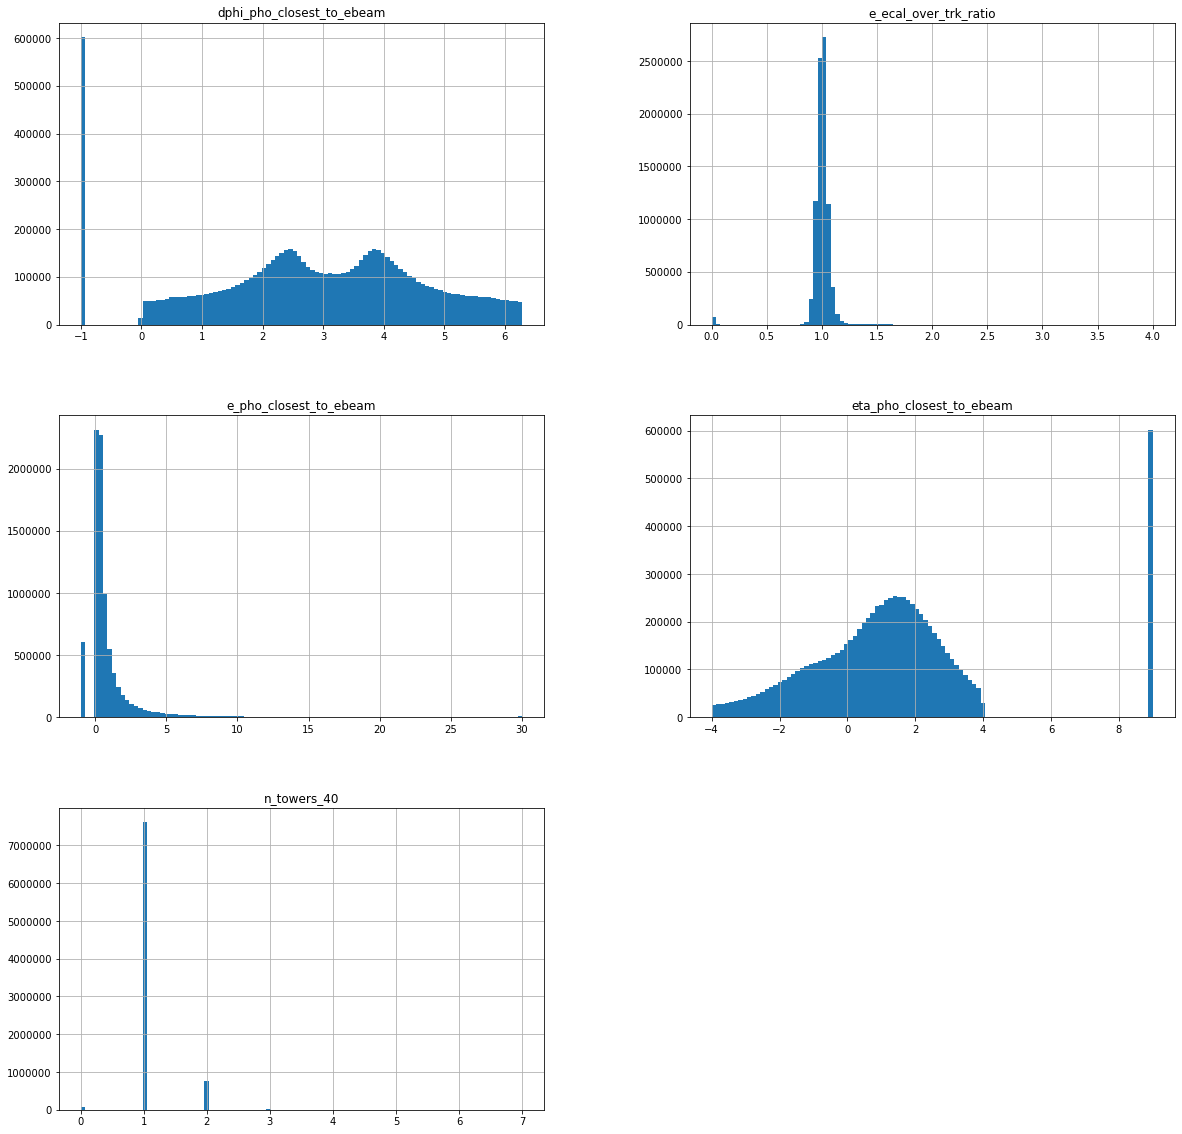

In [9]:

pandas_df.hist( figsize=(20,20), bins=100, column=[
                        'e_ecal_over_trk_ratio','n_towers_40',
                        'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'dphi_pho_closest_to_ebeam'])

plt.show()


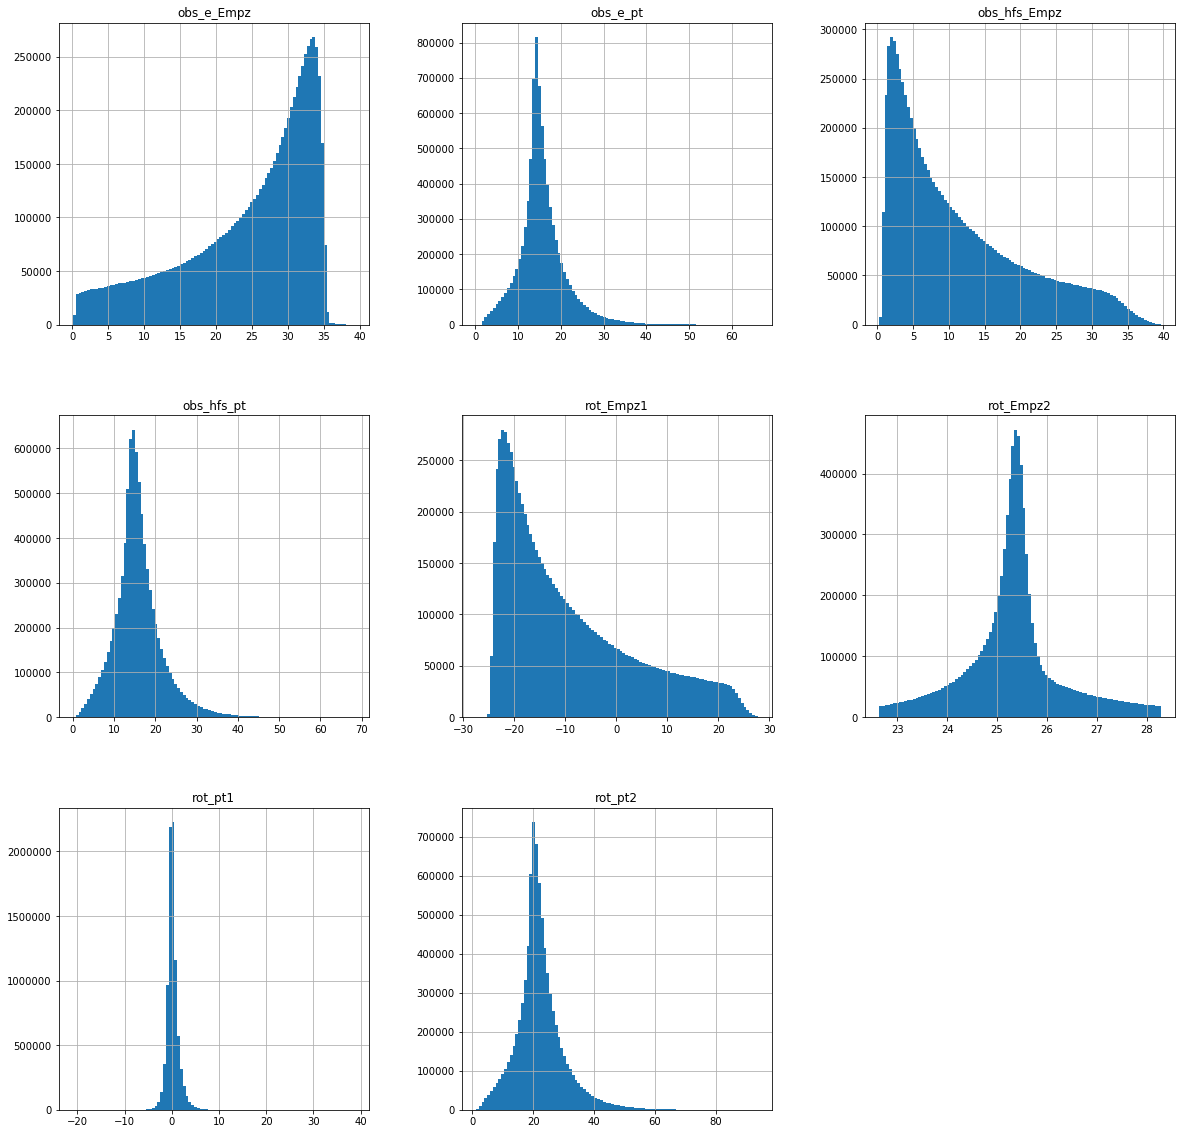

In [10]:
pandas_df.hist( figsize=(20,20), bins=100, column=[
    'obs_e_Empz','obs_hfs_Empz',
    'rot_Empz1','rot_Empz2',
    'obs_hfs_pt','obs_e_pt',
    'rot_pt1','rot_pt2'] )

                                                   
plt.show()

## Set up machine learning stuff

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pickle import dump

#-- Ben suggested to try this.  2021-08-07
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=10,
               verbose=True,
               restore_best_weights=True)

import os

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']="0"
    physical_devices = tf.config.list_physical_devices('GPU') 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

#####physical_devices = tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
X = np.c_[
    pandas_df['e_ecal_over_trk_ratio'].to_numpy(),
    pandas_df['n_towers_40'].to_numpy(),
    pandas_df['eta_pho_closest_to_ebeam'].to_numpy(),
    pandas_df['e_pho_closest_to_ebeam'].to_numpy(),
    pandas_df['dphi_pho_closest_to_ebeam'].to_numpy(),
    pandas_df['obs_e_pz'].to_numpy(),
    pandas_df['obs_e_e'].to_numpy(),
    pandas_df['obs_hfs_pz'].to_numpy(),
    pandas_df['obs_hfs_e'].to_numpy(),
    pandas_df['rot_pt1'].to_numpy(),
    pandas_df['rot_Empz1'].to_numpy(),
    pandas_df['rot_pt2'].to_numpy(),
    pandas_df['rot_Empz2'].to_numpy(),
    pandas_df['obs_dphi'].to_numpy(),
]

#-- targets for classification
Y = np.c_[ 
    pandas_df['has_norad'].to_numpy(),
    pandas_df['has_isr'].to_numpy(),
    pandas_df['has_fsr'].to_numpy(),
]

#-- targets for regression
Y_r = np.c_[
    pandas_df['gen_log_x'].to_numpy(),
    pandas_df['gen_log_Q2'].to_numpy(),
    pandas_df['gen_log_y'].to_numpy(),
]

    
GY = pandas_df['from_tlv_gen_y'].to_numpy()

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

scalerY = StandardScaler()
scalerY.fit(Y_r)
Y_r = scalerY.transform(Y_r)

#-- Save the scaler transformations!  These are essential when reusing the training with a different dataset.

try:
    os.mkdir( '%s-scalers' % training_name )
except:
    print('\n  Dir %s-scalers already exists\n\n' % training_name )

    
print('\n\n Saving the input and learning target scalers:\n')
print('    %s-scalers/input_scaler.pkl' % training_name )
print('    %s-scalers/target_scaler.pkl' % training_name )
dump( scaler, open('%s-scalers/input_scaler.pkl' % training_name , 'wb'))
dump( scalerY, open('%s-scalers/target_scaler.pkl' % training_name , 'wb'))

X_train, X_test,    Y_train, Y_test,    Y_r_train, Y_r_test,    GY_train, GY_test = train_test_split( X, Y, Y_r, GY,  test_size=0.5)
    


  Dir training_athena_classification_v2a-scalers already exists




 Saving the input and learning target scalers:

    training_athena_classification_v2a-scalers/input_scaler.pkl
    training_athena_classification_v2a-scalers/target_scaler.pkl


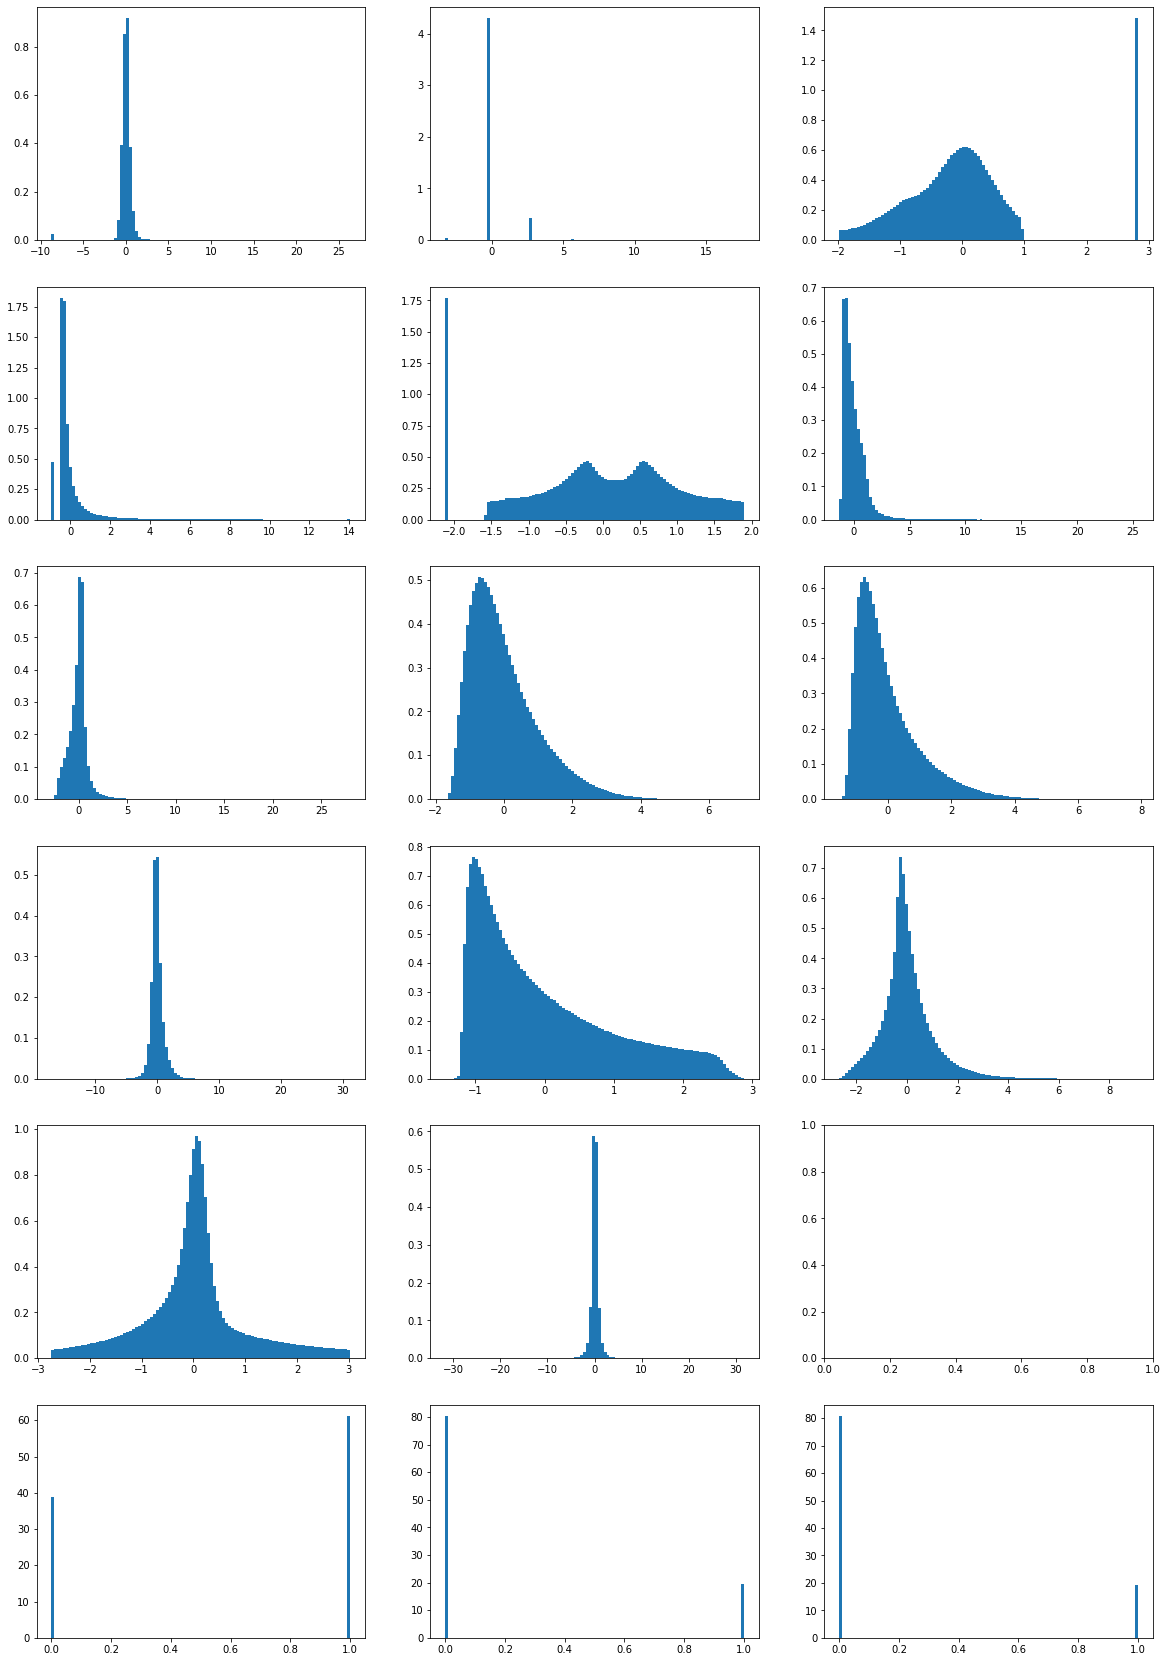

In [13]:
fig,ax = plt.subplots(6,3,figsize=(20,30))

ax[0][0].hist( X[:,0], density=True, bins=100 )
ax[0][1].hist( X[:,1], density=True, bins=100 )
ax[0][2].hist( X[:,2], density=True, bins=100 )

ax[1][0].hist( X[:,3], density=True, bins=100 )
ax[1][1].hist( X[:,4], density=True, bins=100 )
ax[1][2].hist( X[:,5], density=True, bins=100 )

ax[2][0].hist( X[:,6], density=True, bins=100 )
ax[2][1].hist( X[:,7], density=True, bins=100 )
ax[2][2].hist( X[:,8], density=True, bins=100 )

ax[3][0].hist( X[:,9], density=True, bins=100 )
ax[3][1].hist( X[:,10], density=True, bins=100 )
ax[3][2].hist( X[:,11], density=True, bins=100 )

ax[4][0].hist( X[:,12], density=True, bins=100 )
ax[4][1].hist( X[:,13], density=True, bins=100 )



ax[5][0].hist( Y[:,0], density=True, bins=100 )
ax[5][1].hist( Y[:,1], density=True, bins=100 )
ax[5][2].hist( Y[:,2], density=True, bins=100 )

plt.show()

In [14]:
model = Sequential()

#-- initial layer
model.add(Dense(64, input_dim=14, activation='relu'))
model.add(Dropout(dropout_setval))

#-- middle part
model.add(Dense(128, activation='selu'))
model.add(Dropout(dropout_setval))
model.add(Dense(512, activation='selu'))
model.add(Dropout(dropout_setval))
model.add(Dense(1024, activation='selu'))
model.add(Dropout(dropout_setval))
model.add(Dense(512, activation='selu'))
model.add(Dropout(dropout_setval))
model.add(Dense(128, activation='selu'))
model.add(Dropout(dropout_setval))

#-- final layers
model.add(Dense(64, activation='selu'))
model.add(Dense(3, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval)
myloss = tf.keras.losses.CategoricalCrossentropy()

model.compile(loss=myloss, optimizer=opt, metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                960       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              5

In [15]:
%%time

hist = model.fit(
    X_train, Y_train, 
    epochs=max_epochs, batch_size=batch_size_setval, verbose=1, 
    validation_data=(X_test,Y_test), 
    callbacks=[earlystopping] )

Epoch 1/5000
33091/33091 [==============================] - 92s 3ms/step - loss: 0.5976 - accuracy: 0.7775 - val_loss: 0.5891 - val_accuracy: 0.7799
Epoch 2/5000
33091/33091 [==============================] - 91s 3ms/step - loss: 0.5853 - accuracy: 0.7821 - val_loss: 0.5840 - val_accuracy: 0.7823
Epoch 3/5000
33091/33091 [==============================] - 90s 3ms/step - loss: 0.5823 - accuracy: 0.7833 - val_loss: 0.5840 - val_accuracy: 0.7826
Epoch 4/5000
33091/33091 [==============================] - 90s 3ms/step - loss: 0.5804 - accuracy: 0.7841 - val_loss: 0.5815 - val_accuracy: 0.7838
Epoch 5/5000
33091/33091 [==============================] - 90s 3ms/step - loss: 0.5790 - accuracy: 0.7844 - val_loss: 0.5802 - val_accuracy: 0.7838
Epoch 6/5000
33091/33091 [==============================] - 90s 3ms/step - loss: 0.5778 - accuracy: 0.7848 - val_loss: 0.5788 - val_accuracy: 0.7841
Epoch 7/5000
33091/33091 [==============================] - 90s 3ms/step - loss: 0.5769 - accuracy: 0.7852

In [16]:
hist

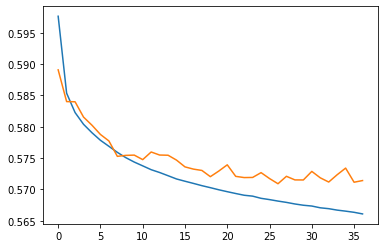

In [17]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

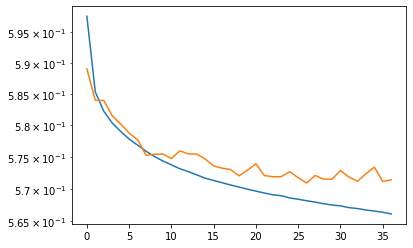

In [18]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.yscale('log')

In [19]:
tf.keras.models.save_model(model, '%s_classifier' % training_name )

INFO:tensorflow:Assets written to: training_athena_classification_v2a_classifier/assets


In [20]:
mypreds = model.predict(X_test,batch_size=1000)

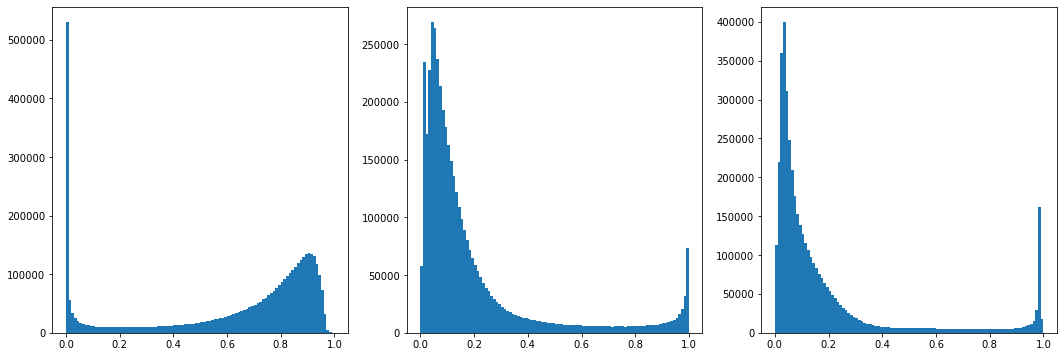

In [21]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
ax[0].hist(mypreds[:,0],bins=100, range=[0,1] )
ax[1].hist(mypreds[:,1],bins=100, range=[0,1] )
ax[2].hist(mypreds[:,2],bins=100, range=[0,1] )
plt.show()

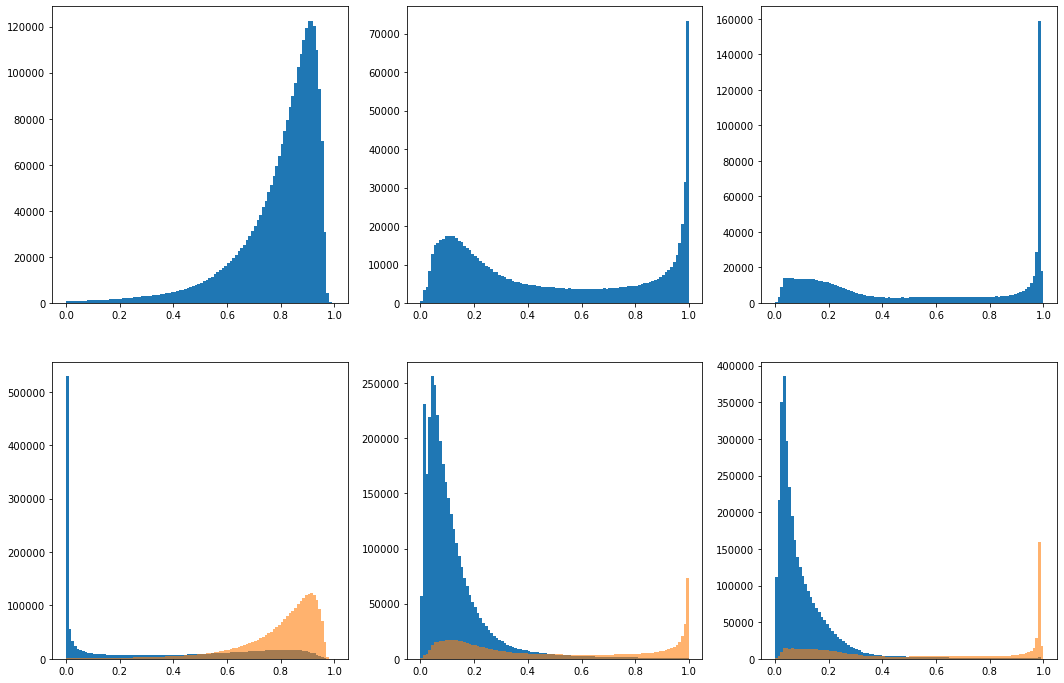

In [22]:
fig,ax = plt.subplots(2,3,figsize=(18,12))

ax[0][0].hist(mypreds[:,0][Y_test[:,0]>0.5],bins=100, range=[0,1] )
ax[0][1].hist(mypreds[:,1][Y_test[:,1]>0.5],bins=100, range=[0,1] )
ax[0][2].hist(mypreds[:,2][Y_test[:,2]>0.5],bins=100, range=[0,1] )

ax[1][0].hist(mypreds[:,0][Y_test[:,0]<0.5],bins=100, range=[0,1] )
ax[1][1].hist(mypreds[:,1][Y_test[:,1]<0.5],bins=100, range=[0,1] )
ax[1][2].hist(mypreds[:,2][Y_test[:,2]<0.5],bins=100, range=[0,1] )

ax[1][0].hist(mypreds[:,0][Y_test[:,0]>0.5],bins=100, range=[0,1], alpha=0.6 )
ax[1][1].hist(mypreds[:,1][Y_test[:,1]>0.5],bins=100, range=[0,1], alpha=0.6 )
ax[1][2].hist(mypreds[:,2][Y_test[:,2]>0.5],bins=100, range=[0,1], alpha=0.6 )



plt.show()

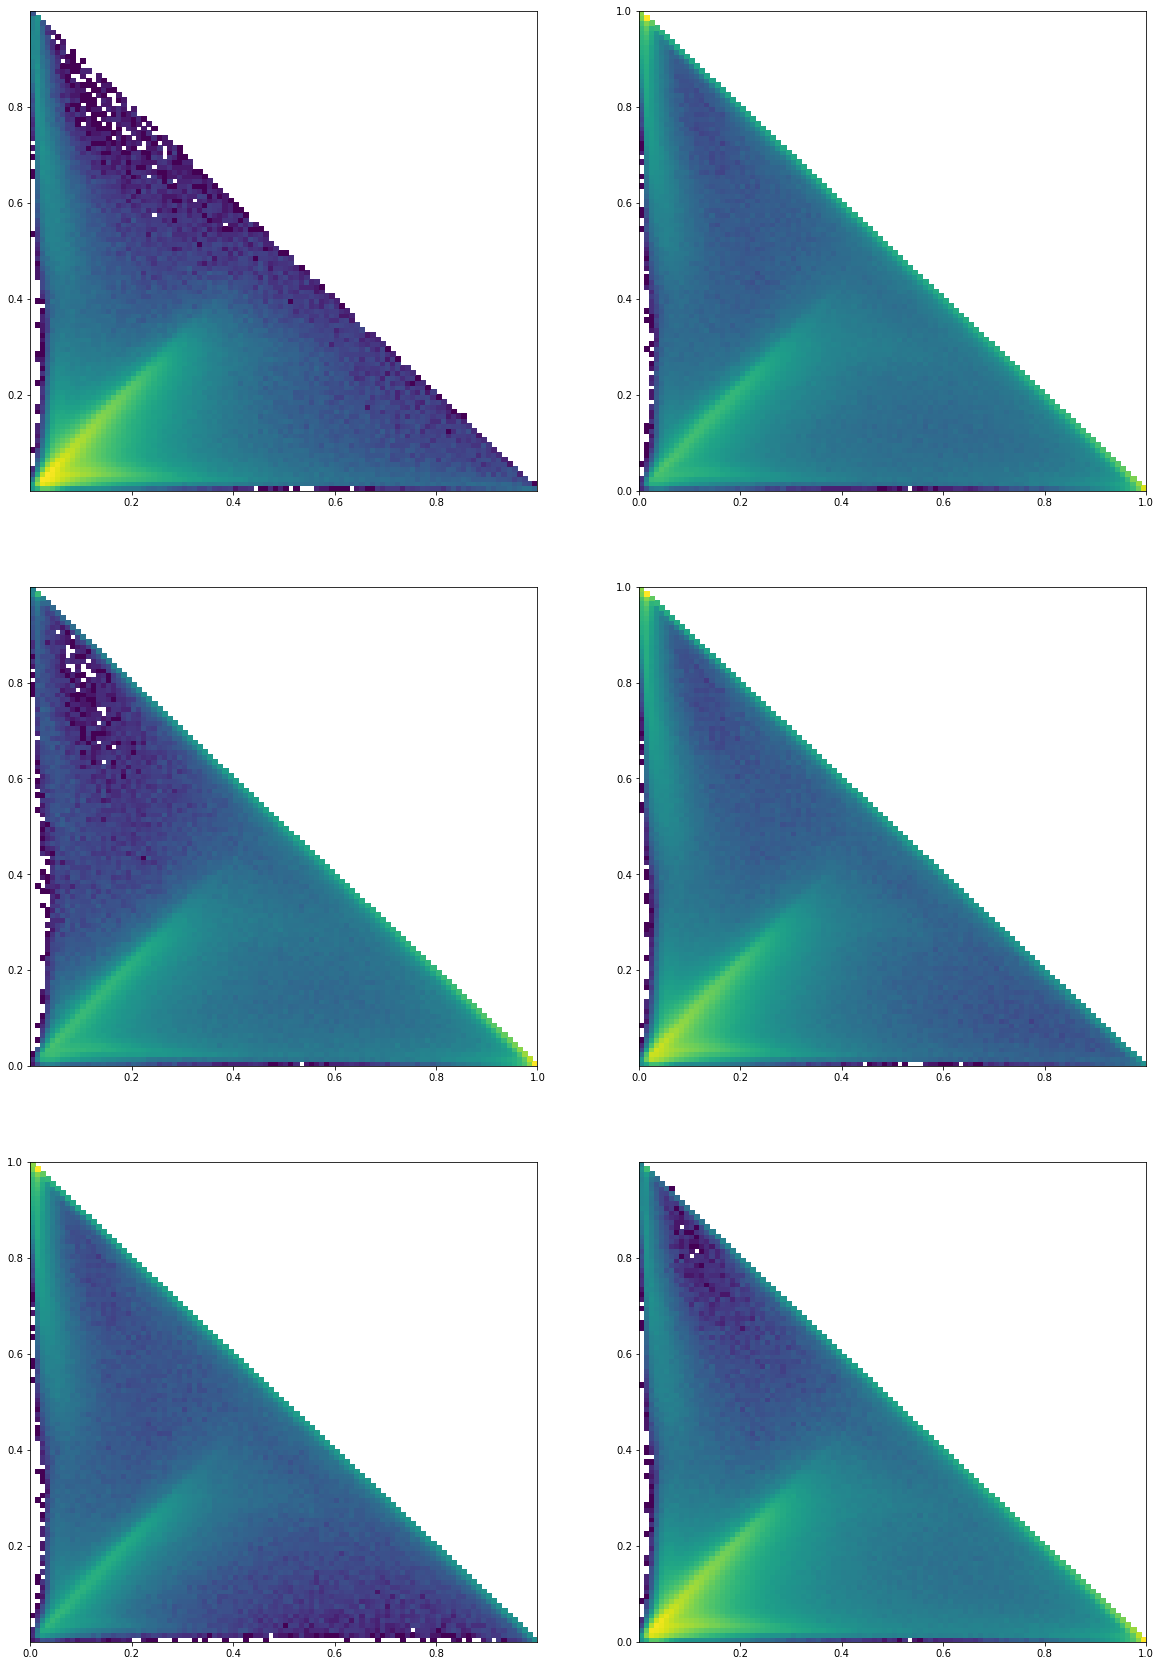

In [23]:
fig,ax = plt.subplots(3,2,figsize=(20,30))

ax[0][0].hist2d( mypreds[:,1][Y_test[:,0]>0.5], mypreds[:,2][Y_test[:,0]>0.5], bins=100, norm=mpl.colors.LogNorm())
ax[0][1].hist2d( mypreds[:,1][Y_test[:,0]<0.5], mypreds[:,2][Y_test[:,0]<0.5], bins=100, norm=mpl.colors.LogNorm())

ax[1][0].hist2d( mypreds[:,1][Y_test[:,1]>0.5], mypreds[:,2][Y_test[:,1]>0.5], bins=100, norm=mpl.colors.LogNorm())
ax[1][1].hist2d( mypreds[:,1][Y_test[:,1]<0.5], mypreds[:,2][Y_test[:,1]<0.5], bins=100, norm=mpl.colors.LogNorm())

ax[2][0].hist2d( mypreds[:,1][Y_test[:,2]>0.5], mypreds[:,2][Y_test[:,2]>0.5], bins=100, norm=mpl.colors.LogNorm())
ax[2][1].hist2d( mypreds[:,1][Y_test[:,2]<0.5], mypreds[:,2][Y_test[:,2]<0.5], bins=100, norm=mpl.colors.LogNorm())



plt.show()

In [24]:
mypreds

array([[7.7166057e-01, 1.6619913e-01, 6.2140316e-02],
       [1.1890028e-09, 2.5774589e-02, 9.7422540e-01],
       [7.5173783e-01, 1.0087591e-01, 1.4738621e-01],
       ...,
       [7.7751976e-01, 1.3766716e-01, 8.4812991e-02],
       [8.0016512e-01, 1.3697091e-01, 6.2863946e-02],
       [4.9751809e-01, 2.4735197e-01, 2.5512984e-01]], dtype=float32)

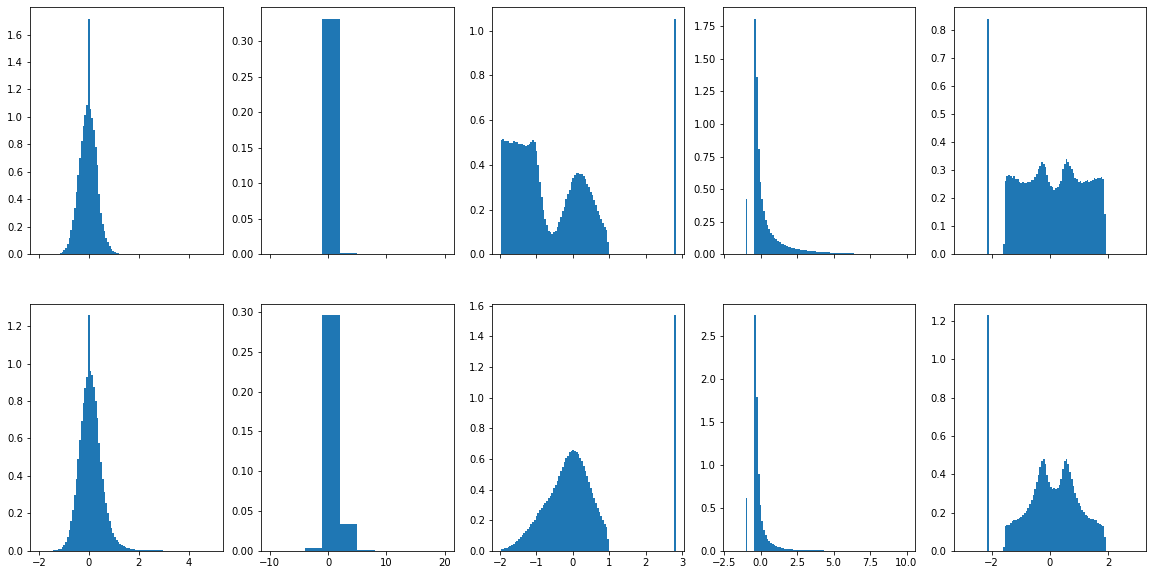

In [25]:
fig,ax = plt.subplots(2,5,figsize=(20,10), sharex='col')

ax[0][0].hist( X_test[:,0][mypreds[:,1]>0.5], density=True, range=(-2,5), bins=100 )
ax[0][1].hist( X_test[:,1][mypreds[:,1]>0.5], density=True, range=(-10,20), bins=10 )
ax[0][2].hist( X_test[:,2][mypreds[:,1]>0.5], density=True, bins=100 )
ax[0][3].hist( X_test[:,3][mypreds[:,1]>0.5], density=True, range=(-2,10), bins=100 )
ax[0][4].hist( X_test[:,4][mypreds[:,1]>0.5], density=True, range=(-3,3), bins=100 )

ax[1][0].hist( X_test[:,0][mypreds[:,1]<0.5], density=True, range=(-2,5), bins=100 )
ax[1][1].hist( X_test[:,1][mypreds[:,1]<0.5], density=True, range=(-10,20), bins=10 )
ax[1][2].hist( X_test[:,2][mypreds[:,1]<0.5], density=True, bins=100 )
ax[1][3].hist( X_test[:,3][mypreds[:,1]<0.5], density=True, range=(-2,10), bins=100 )
ax[1][4].hist( X_test[:,4][mypreds[:,1]<0.5], density=True, range=(-3,3), bins=100 )


plt.show()

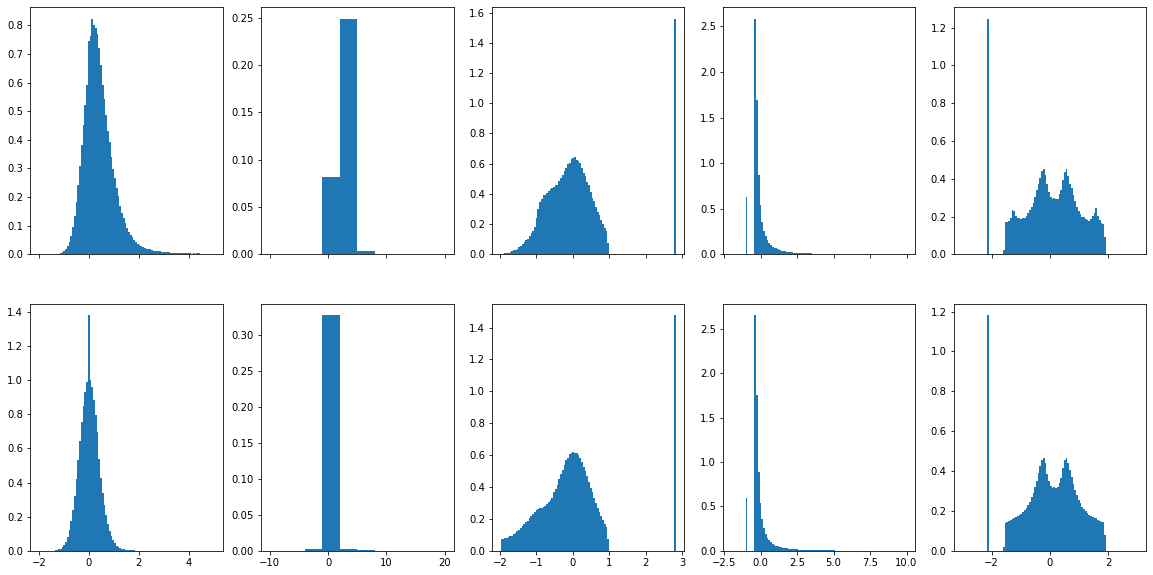

In [26]:
fig,ax = plt.subplots(2,5,figsize=(20,10), sharex='col')

ax[0][0].hist( X_test[:,0][mypreds[:,2]>0.5], density=True, range=(-2,5), bins=100 )
ax[0][1].hist( X_test[:,1][mypreds[:,2]>0.5], density=True, range=(-10,20), bins=10 )
ax[0][2].hist( X_test[:,2][mypreds[:,2]>0.5], density=True, bins=100 )
ax[0][3].hist( X_test[:,3][mypreds[:,2]>0.5], density=True, range=(-2,10), bins=100 )
ax[0][4].hist( X_test[:,4][mypreds[:,2]>0.5], density=True, range=(-3,3), bins=100 )

ax[1][0].hist( X_test[:,0][mypreds[:,2]<0.5], density=True, range=(-2,5), bins=100 )
ax[1][1].hist( X_test[:,1][mypreds[:,2]<0.5], density=True, range=(-10,20), bins=10 )
ax[1][2].hist( X_test[:,2][mypreds[:,2]<0.5], density=True, bins=100 )
ax[1][3].hist( X_test[:,3][mypreds[:,2]<0.5], density=True, range=(-2,10), bins=100 )
ax[1][4].hist( X_test[:,4][mypreds[:,2]<0.5], density=True, range=(-3,3), bins=100 )


plt.show()

## Now, add classification outputs to the set of inputs for the regression

In [27]:
X_train

array([[ 0.17438017, -0.26701567,  2.82211249, ...,  0.16604153,
        -0.98540539,  0.25922912],
       [ 0.35580704, -0.26701567, -0.43147004, ...,  0.23007189,
        -0.10859269,  0.13792932],
       [-0.02642682, -0.26701567, -1.58142921, ..., -0.16211277,
         0.13225985,  0.05233961],
       ...,
       [ 0.05377728, -0.26701567, -1.41592991, ..., -1.65746754,
         2.47199566,  3.21884843],
       [-0.18071722, -0.26701567,  2.82211249, ...,  1.49254345,
        -0.44200061, -0.22539752],
       [ 0.11077188, -0.26701567, -0.75622241, ..., -0.65954777,
        -0.4671371 , -0.61460719]])

In [28]:
mypreds_train = model.predict(X_train,batch_size=1000)

In [29]:
mypreds_train

array([[6.6607338e-01, 2.3979153e-01, 9.4135083e-02],
       [7.5693589e-01, 1.2946884e-01, 1.1359522e-01],
       [2.3014298e-05, 9.9225372e-01, 7.7232653e-03],
       ...,
       [8.1041348e-01, 1.5157264e-01, 3.8013808e-02],
       [4.6305826e-01, 3.5667375e-01, 1.8026802e-01],
       [9.3574679e-01, 4.3098953e-02, 2.1154258e-02]], dtype=float32)

In [30]:
X_merged_train = np.append(X_train, mypreds_train,1)

In [31]:
X_merged_train

array([[ 1.74380173e-01, -2.67015669e-01,  2.82211249e+00, ...,
         6.66073382e-01,  2.39791527e-01,  9.41350833e-02],
       [ 3.55807037e-01, -2.67015669e-01, -4.31470043e-01, ...,
         7.56935894e-01,  1.29468843e-01,  1.13595217e-01],
       [-2.64268202e-02, -2.67015669e-01, -1.58142921e+00, ...,
         2.30142978e-05,  9.92253721e-01,  7.72326533e-03],
       ...,
       [ 5.37772753e-02, -2.67015669e-01, -1.41592991e+00, ...,
         8.10413480e-01,  1.51572645e-01,  3.80138084e-02],
       [-1.80717223e-01, -2.67015669e-01,  2.82211249e+00, ...,
         4.63058263e-01,  3.56673747e-01,  1.80268019e-01],
       [ 1.10771882e-01, -2.67015669e-01, -7.56222407e-01, ...,
         9.35746789e-01,  4.30989526e-02,  2.11542584e-02]])

In [32]:
X_test

array([[-0.46423441, -0.26701567, -1.42271009, ..., -2.23107281,
        -1.3494341 ,  6.78617198],
       [ 0.9462028 , -0.26701567,  0.57239184, ...,  3.74188493,
        -1.03116475, -0.02840984],
       [ 0.58116922, -0.26701567,  0.35820525, ...,  2.64072308,
         0.40963678, -0.01933557],
       ...,
       [ 0.0532605 , -0.26701567,  0.11682858, ..., -0.49570395,
        -0.33582282,  0.82832681],
       [-0.37803937, -0.26701567, -0.48867904, ...,  0.80538316,
         2.45574275,  0.73328274],
       [ 0.624522  , -0.26701567,  0.54860163, ...,  3.21021328,
        -0.78551711,  0.22954769]])

In [33]:
mypreds

array([[7.7166057e-01, 1.6619913e-01, 6.2140316e-02],
       [1.1890028e-09, 2.5774589e-02, 9.7422540e-01],
       [7.5173783e-01, 1.0087591e-01, 1.4738621e-01],
       ...,
       [7.7751976e-01, 1.3766716e-01, 8.4812991e-02],
       [8.0016512e-01, 1.3697091e-01, 6.2863946e-02],
       [4.9751809e-01, 2.4735197e-01, 2.5512984e-01]], dtype=float32)

In [34]:
X_merged_test = np.append(X_test, mypreds,1)

In [35]:
X_merged_test

array([[-4.64234412e-01, -2.67015669e-01, -1.42271009e+00, ...,
         7.71660566e-01,  1.66199133e-01,  6.21403158e-02],
       [ 9.46202804e-01, -2.67015669e-01,  5.72391844e-01, ...,
         1.18900279e-09,  2.57745888e-02,  9.74225402e-01],
       [ 5.81169223e-01, -2.67015669e-01,  3.58205252e-01, ...,
         7.51737833e-01,  1.00875907e-01,  1.47386208e-01],
       ...,
       [ 5.32604997e-02, -2.67015669e-01,  1.16828582e-01, ...,
         7.77519763e-01,  1.37667164e-01,  8.48129913e-02],
       [-3.78039374e-01, -2.67015669e-01, -4.88679035e-01, ...,
         8.00165117e-01,  1.36970907e-01,  6.28639460e-02],
       [ 6.24521998e-01, -2.67015669e-01,  5.48601626e-01, ...,
         4.97518092e-01,  2.47351974e-01,  2.55129844e-01]])

In [36]:
len(X_merged_test[0])

17

## Set up the regression network

In [37]:
model_r = Sequential()

#-- initial layer
model_r.add(Dense(64, input_dim=17, activation='relu'))
model_r.add(Dropout(dropout_setval))

#-- middle part
model_r.add(Dense(128, activation='selu'))
model_r.add(Dropout(dropout_setval))
model_r.add(Dense(512, activation='selu'))
model_r.add(Dropout(dropout_setval))
model_r.add(Dense(1024, activation='selu'))
model_r.add(Dropout(dropout_setval))
model_r.add(Dense(512, activation='selu'))
model_r.add(Dropout(dropout_setval))
model_r.add(Dense(128, activation='selu'))
model_r.add(Dropout(dropout_setval))

#-- final layers
model_r.add(Dense(64, activation='selu'))
model_r.add(Dense(3, activation='linear'))

opt_r = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval)
myloss_r = tf.keras.losses.Huber()

model_r.compile(loss=myloss_r, optimizer=opt_r, metrics=['accuracy'])

model_r.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                1152      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)             

In [38]:
%%time

hist_r = model_r.fit(
    X_merged_train, Y_r_train, 
    epochs=max_epochs, batch_size=batch_size_setval, verbose=1, 
    validation_data=(X_merged_test,Y_r_test), 
    callbacks=[earlystopping] )

Epoch 1/5000
33091/33091 [==============================] - 95s 3ms/step - loss: 0.0041 - accuracy: 0.9763 - val_loss: 0.0028 - val_accuracy: 0.9801
Epoch 2/5000
33091/33091 [==============================] - 94s 3ms/step - loss: 0.0025 - accuracy: 0.9818 - val_loss: 0.0024 - val_accuracy: 0.9819
Epoch 3/5000
33091/33091 [==============================] - 94s 3ms/step - loss: 0.0022 - accuracy: 0.9828 - val_loss: 0.0022 - val_accuracy: 0.9834
Epoch 4/5000
33091/33091 [==============================] - 94s 3ms/step - loss: 0.0021 - accuracy: 0.9833 - val_loss: 0.0021 - val_accuracy: 0.9836
Epoch 5/5000
33091/33091 [==============================] - 94s 3ms/step - loss: 0.0020 - accuracy: 0.9837 - val_loss: 0.0020 - val_accuracy: 0.9845
Epoch 6/5000
33091/33091 [==============================] - 94s 3ms/step - loss: 0.0020 - accuracy: 0.9840 - val_loss: 0.0020 - val_accuracy: 0.9833
Epoch 7/5000
33091/33091 [==============================] - 95s 3ms/step - loss: 0.0019 - accuracy: 0.9842

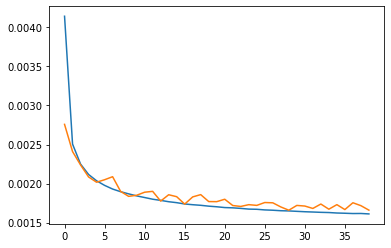

In [39]:
plt.plot(hist_r.history['loss'])
plt.plot(hist_r.history['val_loss'])

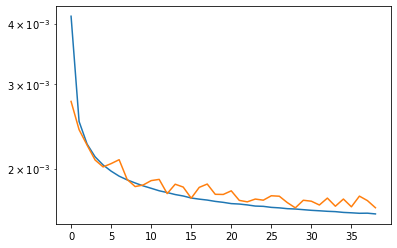

In [40]:
plt.plot(hist_r.history['loss'])
plt.plot(hist_r.history['val_loss'])
plt.yscale('log')

In [41]:
tf.keras.models.save_model(model_r, '%s_regression' % training_name )

INFO:tensorflow:Assets written to: training_athena_classification_v2a_regression/assets


In [42]:
mypreds_r = model_r.predict(X_merged_test,batch_size=1000)

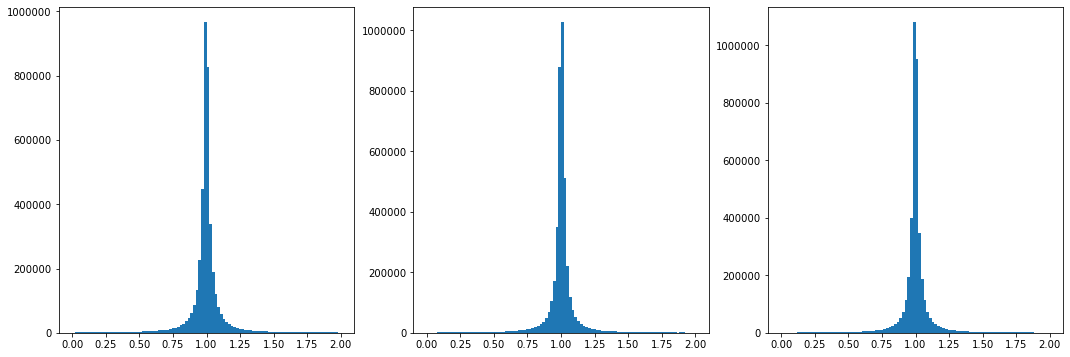

In [43]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
ax[0].hist(mypreds_r[:,0]/Y_r_test[:,0],bins=100, range=[0,2] )
ax[1].hist(mypreds_r[:,1]/Y_r_test[:,1],bins=100, range=[0,2] )
ax[2].hist(mypreds_r[:,2]/Y_r_test[:,2],bins=100, range=[0,2] )
plt.show()

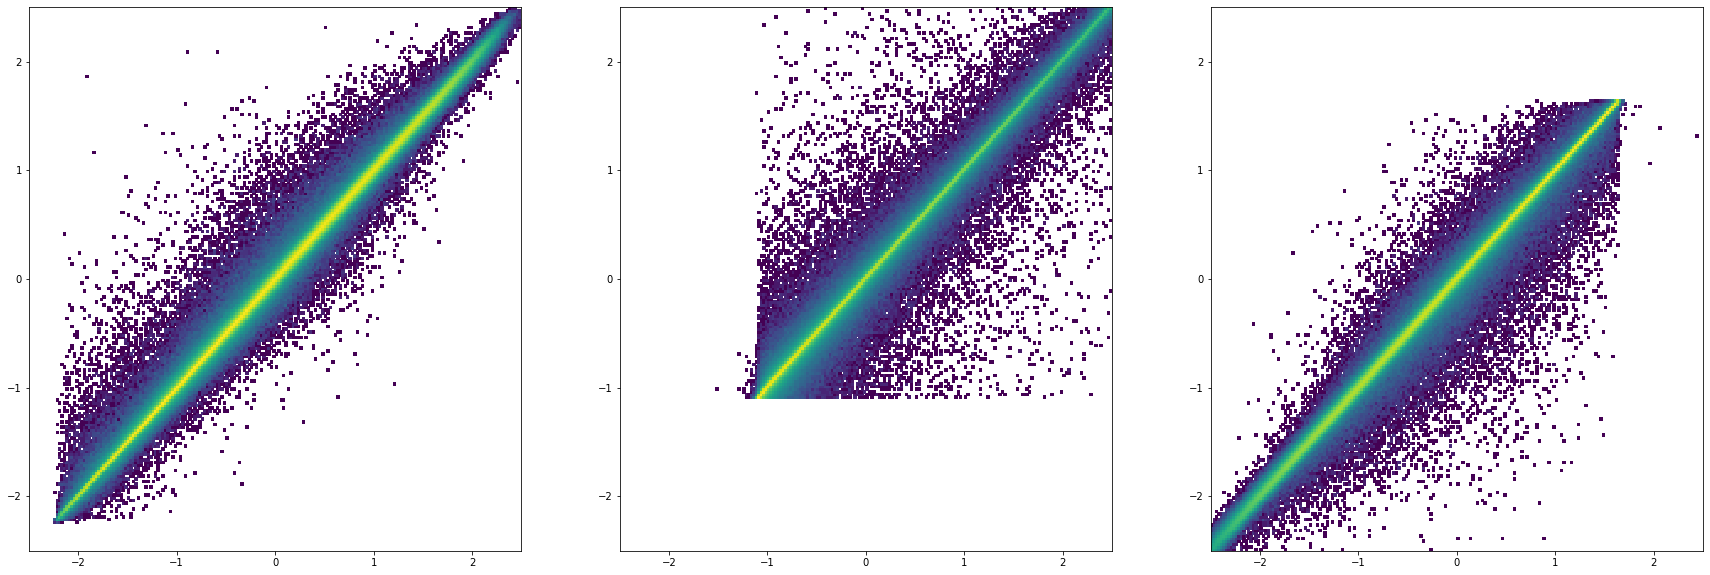

In [44]:
fig,ax = plt.subplots(1,3,figsize=(30,10))
ax[0].hist2d(mypreds_r[:,0],Y_r_test[:,0],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
ax[1].hist2d(mypreds_r[:,1],Y_r_test[:,1],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
ax[2].hist2d(mypreds_r[:,2],Y_r_test[:,2],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
plt.show()

In [45]:
inv_trans_Y = scalerY.inverse_transform(Y_r_test)
inv_trans_pred = scalerY.inverse_transform(mypreds_r)
true_vals = np.exp( inv_trans_Y )
pred_vals = np.exp( inv_trans_pred )

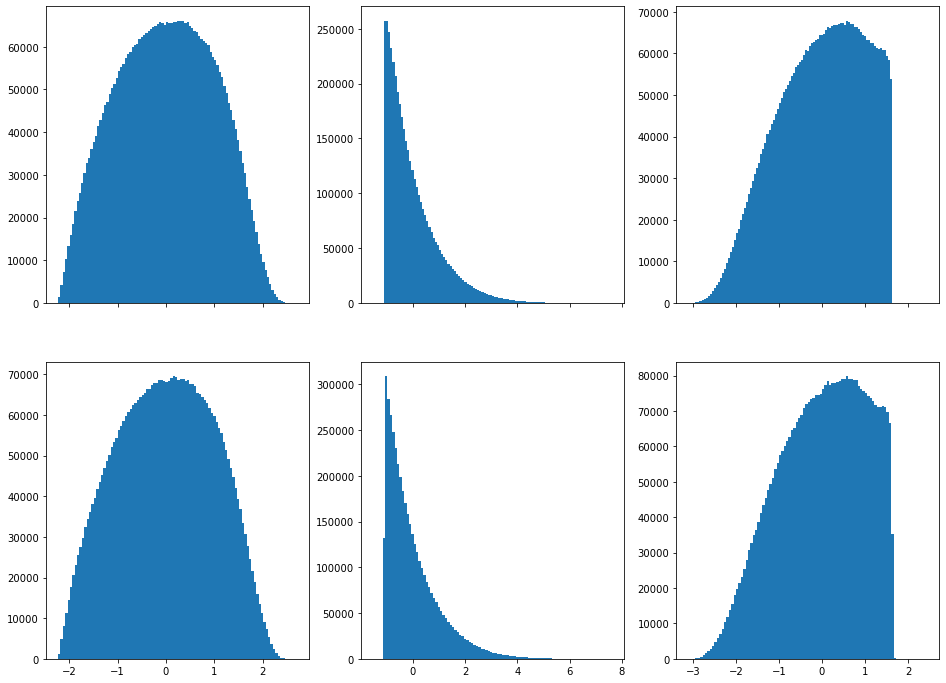

In [46]:
fig,ax = plt.subplots(2,3,figsize=(16,12), sharex='col')

ax[0][0].hist(Y_r_test[:,0], bins=100)
ax[0][1].hist(Y_r_test[:,1], bins=100)
ax[0][2].hist(Y_r_test[:,2], bins=100)

ax[1][0].hist(mypreds_r[:,0], bins=100)
ax[1][1].hist(mypreds_r[:,1], bins=100)
ax[1][2].hist(mypreds_r[:,2], bins=100)


plt.show()

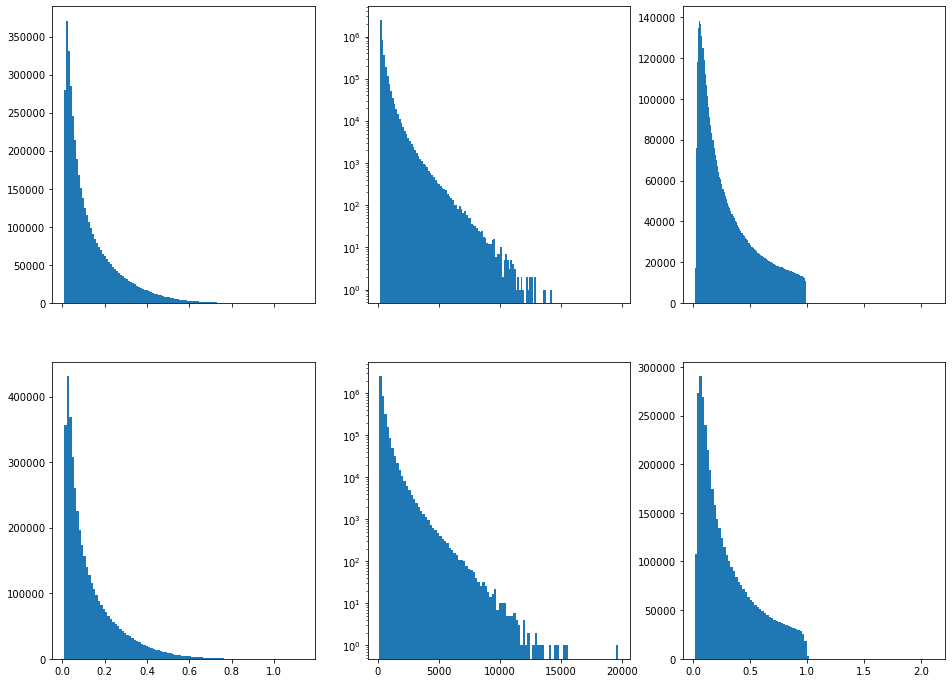

In [47]:
fig,ax = plt.subplots(2,3,figsize=(16,12), sharex='col' )



ax[0][0].hist(true_vals[:,0], bins=100)
ax[0][1].hist(true_vals[:,1], bins=100)
ax[0][2].hist(true_vals[:,2], bins=100)

ax[1][0].hist(pred_vals[:,0], bins=100)
ax[1][1].hist(pred_vals[:,1], bins=100)
ax[1][2].hist(pred_vals[:,2], bins=100)


ax[0][1].set_yscale('log')
ax[1][1].set_yscale('log')


plt.show()

## Plots of pred/true of training target variables : transformed log(x), log(y), and log(Q2)

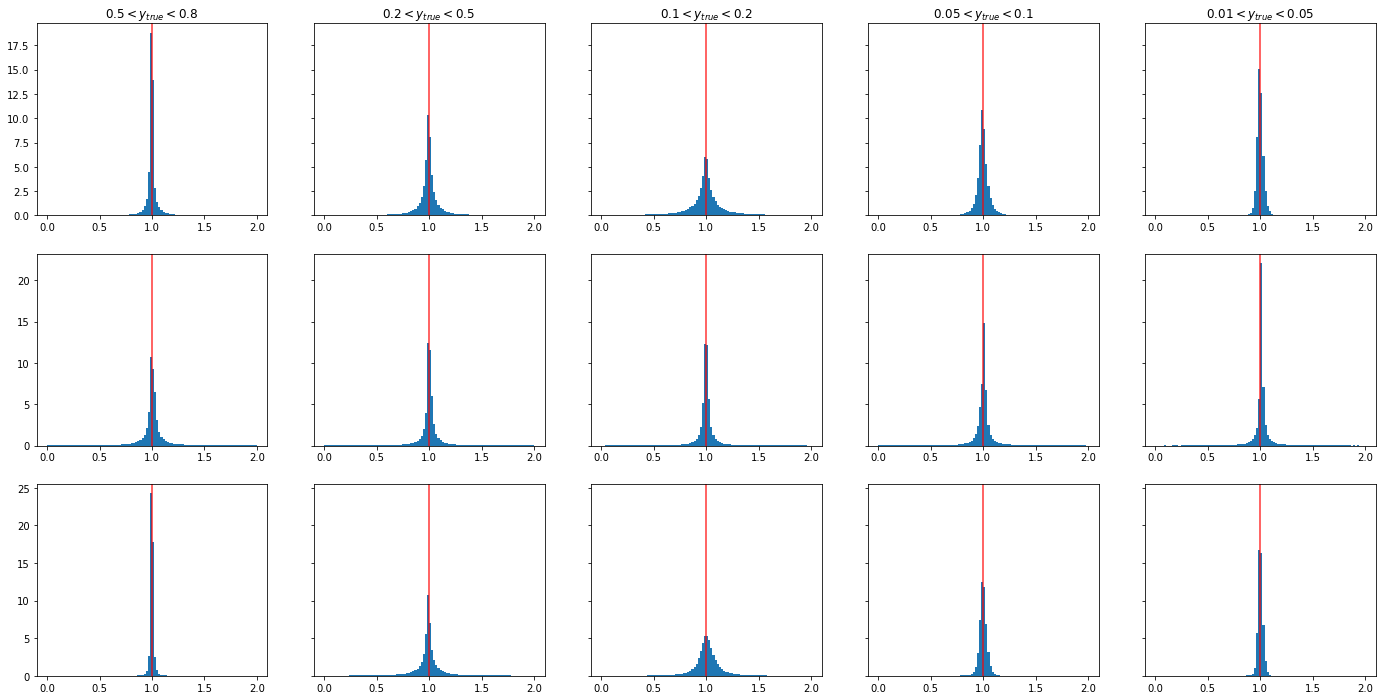

In [48]:
fig,ax = plt.subplots(3,5,figsize=(24,12),sharey='row')

for i in range(3):
    ax[i][0].hist(mypreds_r[:,i][(GY_test > 0.5)*(GY_test < 0.8)]/Y_r_test[(GY_test > 0.5)*(GY_test < 0.8)][:,i],density=True,bins=100,range=(0,2))
    ax[i][1].hist(mypreds_r[:,i][(GY_test > 0.2)*(GY_test < 0.5)]/Y_r_test[(GY_test > 0.2)*(GY_test < 0.5)][:,i],density=True,bins=100,range=(0,2))
    ax[i][2].hist(mypreds_r[:,i][(GY_test > 0.1)*(GY_test < 0.2)]/Y_r_test[(GY_test > 0.1)*(GY_test < 0.2)][:,i],density=True,bins=100,range=(0,2))
    ax[i][3].hist(mypreds_r[:,i][(GY_test > 0.05)*(GY_test < 0.1)]/Y_r_test[(GY_test > 0.05)*(GY_test < 0.1)][:,i],density=True,bins=100,range=(0,2))
    ax[i][4].hist(mypreds_r[:,i][(GY_test > 0.01)*(GY_test < 0.05)]/Y_r_test[(GY_test > 0.01)*(GY_test < 0.05)][:,i],density=True,bins=100,range=(0,2))



ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[0][i].axvline(1.0,color='red',lw=2,alpha=0.6)
    ax[1][i].axvline(1.0,color='red',lw=2,alpha=0.6)
    ax[2][i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()


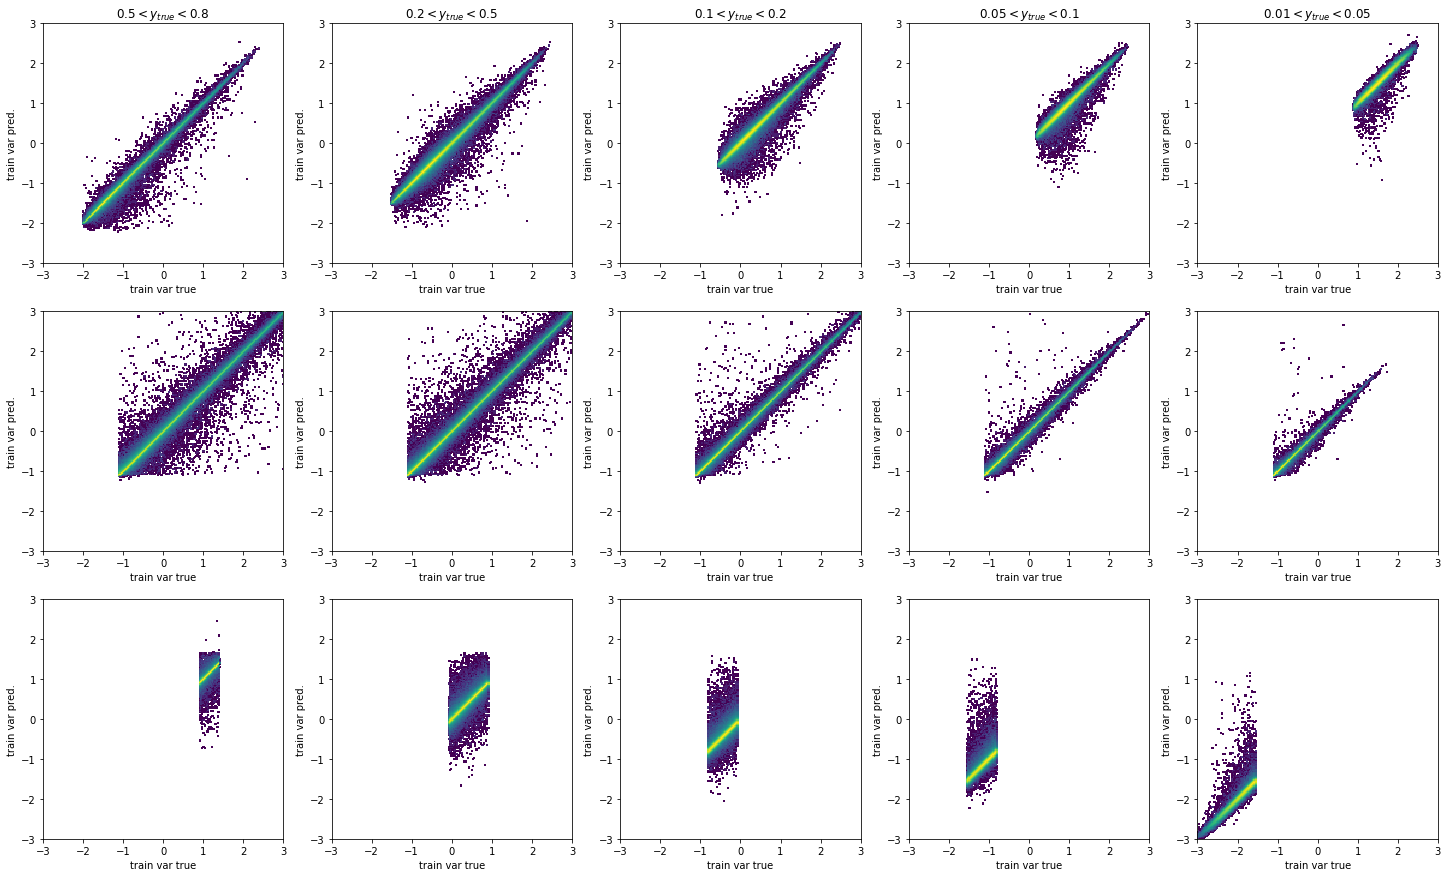

In [49]:
fig,ax = plt.subplots(3,5,figsize=(25,15))


for i in range(3):
    ax[i][0].hist2d( Y_r_test[(GY_test > 0.5)*(GY_test < 0.8)][:,i],
              mypreds_r[:,i][(GY_test > 0.5)*(GY_test < 0.8)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

    ax[i][1].hist2d( Y_r_test[(GY_test > 0.2)*(GY_test < 0.5)][:,i],
              mypreds_r[:,i][(GY_test > 0.2)*(GY_test < 0.5)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

    ax[i][2].hist2d( Y_r_test[(GY_test > 0.1)*(GY_test < 0.2)][:,i],
              mypreds_r[:,i][(GY_test > 0.1)*(GY_test < 0.2)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

    ax[i][3].hist2d( Y_r_test[(GY_test > 0.05)*(GY_test < 0.1)][:,i],
              mypreds_r[:,i][(GY_test > 0.05)*(GY_test < 0.1)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

    ax[i][4].hist2d( Y_r_test[(GY_test > 0.01)*(GY_test < 0.05)][:,i],
              mypreds_r[:,i][(GY_test > 0.01)*(GY_test < 0.05)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())
    
ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')




for i in range(5):
    ax[0][i].set_ylabel('train var pred.')
    ax[0][i].set_xlabel('train var true')
    ax[1][i].set_ylabel('train var pred.')
    ax[1][i].set_xlabel('train var true')
    ax[2][i].set_ylabel('train var pred.')
    ax[2][i].set_xlabel('train var true')



    
plt.show()


## Plots of predicted and true physics variable : x

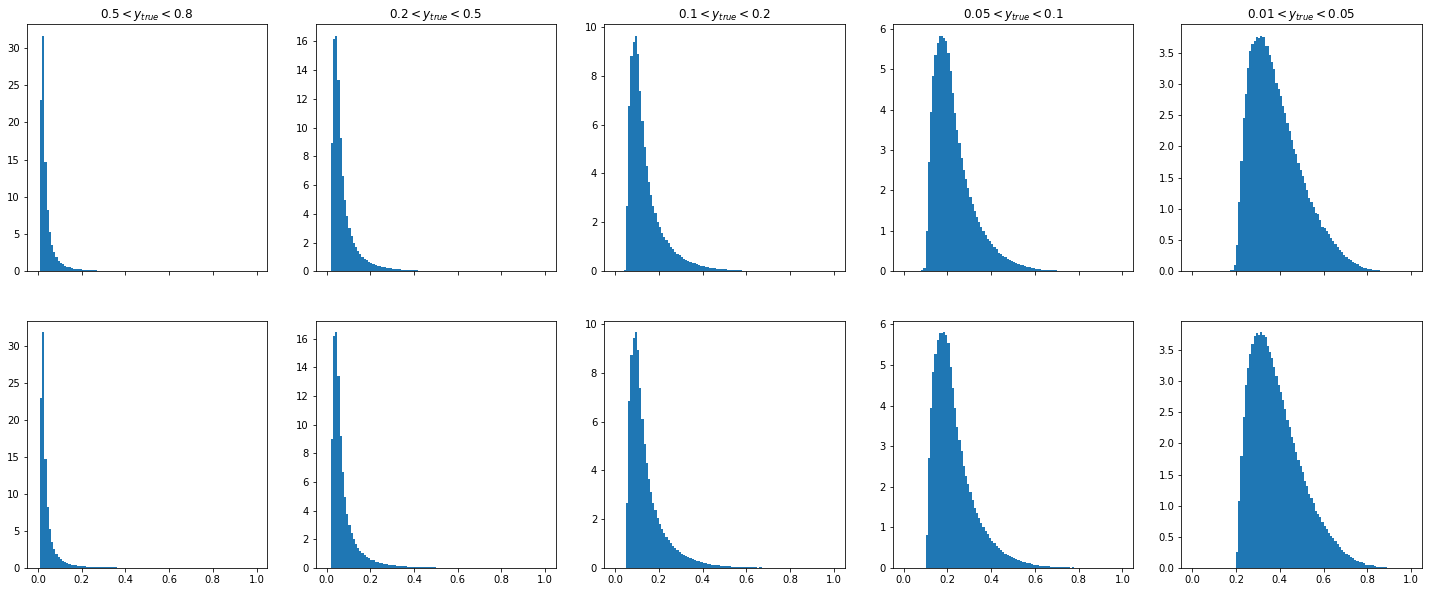

In [50]:
fig,ax = plt.subplots(2,5,figsize=(25,10),sharex='col')

ax[0][0].hist(pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,1))
ax[0][1].hist(pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,1))
ax[0][2].hist(pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,1))
ax[0][3].hist(pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,1))
ax[0][4].hist(pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,1))

ax[1][0].hist(true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,1))
ax[1][1].hist(true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,1))
ax[1][2].hist(true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,1))
ax[1][3].hist(true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,1))
ax[1][4].hist(true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,1))


ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


    
plt.show()

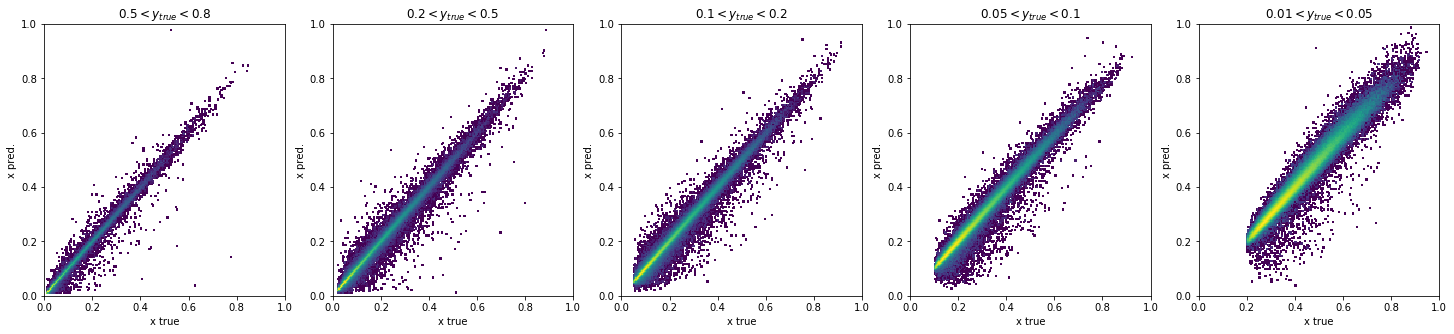

In [51]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

ax[0].hist2d( true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)],
              pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())

ax[1].hist2d( true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)],
              pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[2].hist2d( true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)],
              pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[3].hist2d( true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)],
              pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[4].hist2d( true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)],
              pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())








ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('x pred.')
    ax[i].set_xlabel('x true')


    
plt.show()

## Plots of predicted and true physics variable : Q2

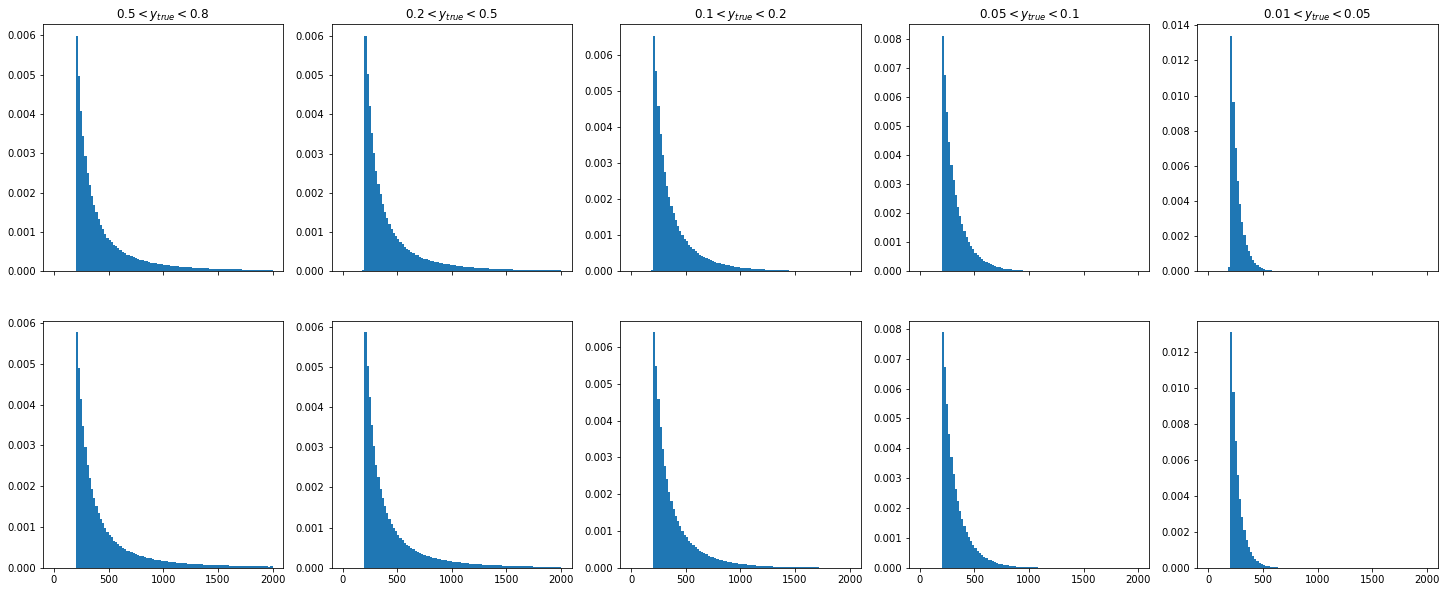

In [52]:
fig,ax = plt.subplots(2,5,figsize=(25,10),sharex='col')

xmax = 2000

ax[0][0].hist(pred_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[0][1].hist(pred_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[0][2].hist(pred_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[0][3].hist(pred_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[0][4].hist(pred_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,xmax))

ax[1][0].hist(true_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[1][1].hist(true_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[1][2].hist(true_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[1][3].hist(true_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[1][4].hist(true_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,xmax))


ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


    
plt.show()

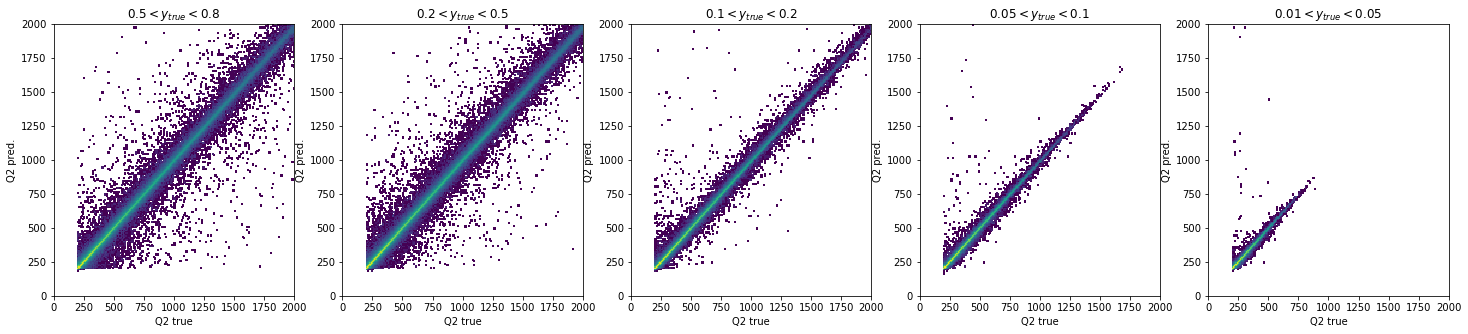

In [53]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

axis_max = 2000

ax[0].hist2d( true_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)],
              pred_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())

ax[1].hist2d( true_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)],
              pred_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[2].hist2d( true_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)],
              pred_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[3].hist2d( true_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)],
              pred_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[4].hist2d( true_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)],
              pred_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())








ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('Q2 pred.')
    ax[i].set_xlabel('Q2 true')


    
plt.show()

## Plots of predicted and true physics variable : y

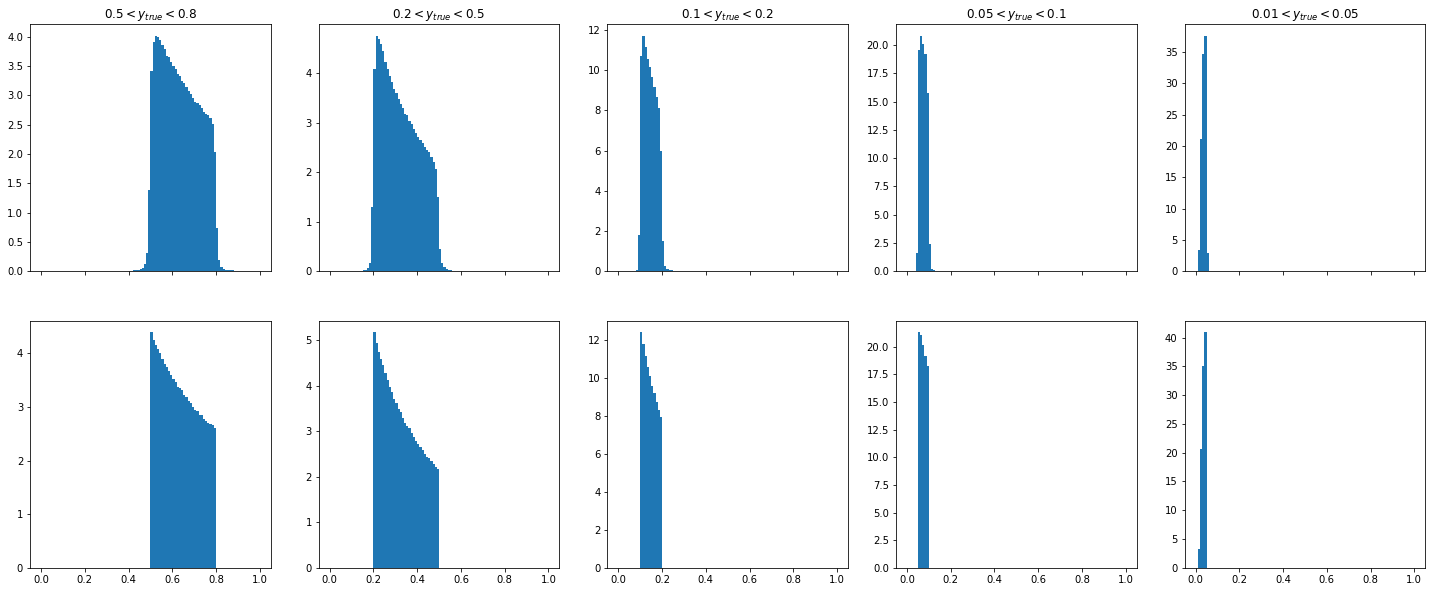

In [54]:
fig,ax = plt.subplots(2,5,figsize=(25,10),sharex='col')

xmax = 1

ax[0][0].hist(pred_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[0][1].hist(pred_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[0][2].hist(pred_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[0][3].hist(pred_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[0][4].hist(pred_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,xmax))

ax[1][0].hist(true_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[1][1].hist(true_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[1][2].hist(true_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[1][3].hist(true_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[1][4].hist(true_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,xmax))


ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


    
plt.show()

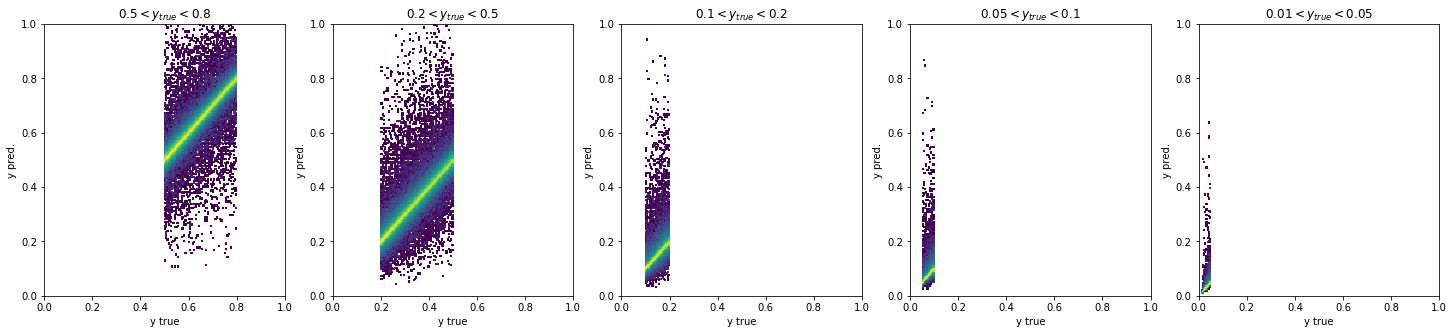

In [55]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

axis_max = 1

ax[0].hist2d( true_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)],
              pred_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())

ax[1].hist2d( true_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)],
              pred_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[2].hist2d( true_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)],
              pred_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[3].hist2d( true_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)],
              pred_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[4].hist2d( true_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)],
              pred_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())








ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('y pred.')
    ax[i].set_xlabel('y true')


    
plt.show()

## Plots of pred/true of physics variable x

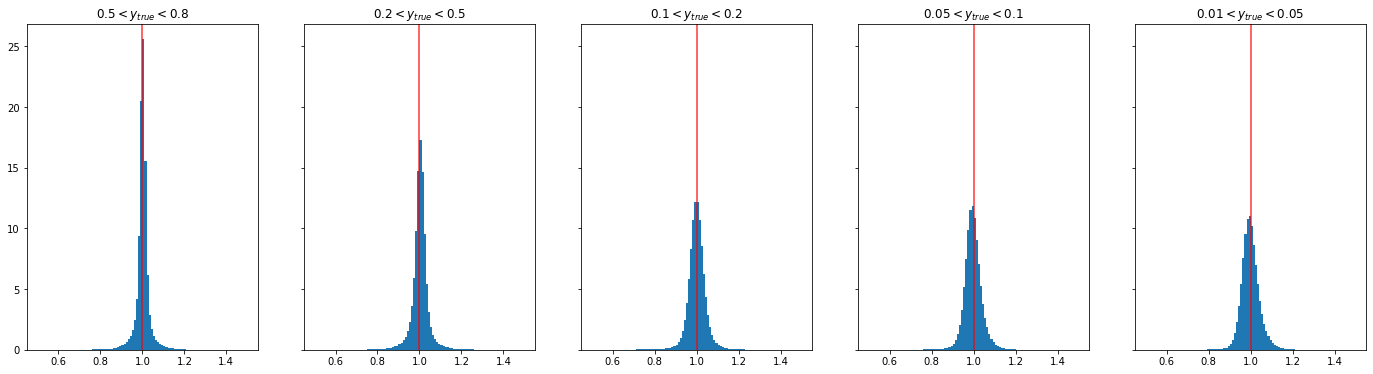

In [56]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

xmin = 0.5
xmax = 1.5

ax[0].hist(pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1].hist(pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2].hist(pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3].hist(pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4].hist(pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))






ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Plots of pred/true of physics variable Q2

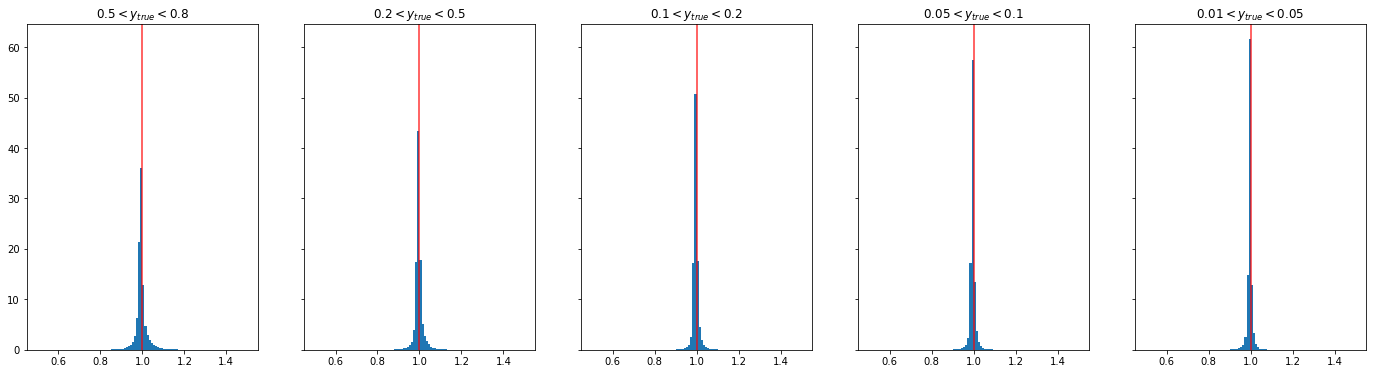

In [57]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

xmin = 0.5
xmax = 1.5

ax[0].hist(pred_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1].hist(pred_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2].hist(pred_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3].hist(pred_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4].hist(pred_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))






ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Plots of pred/true of physics variable y

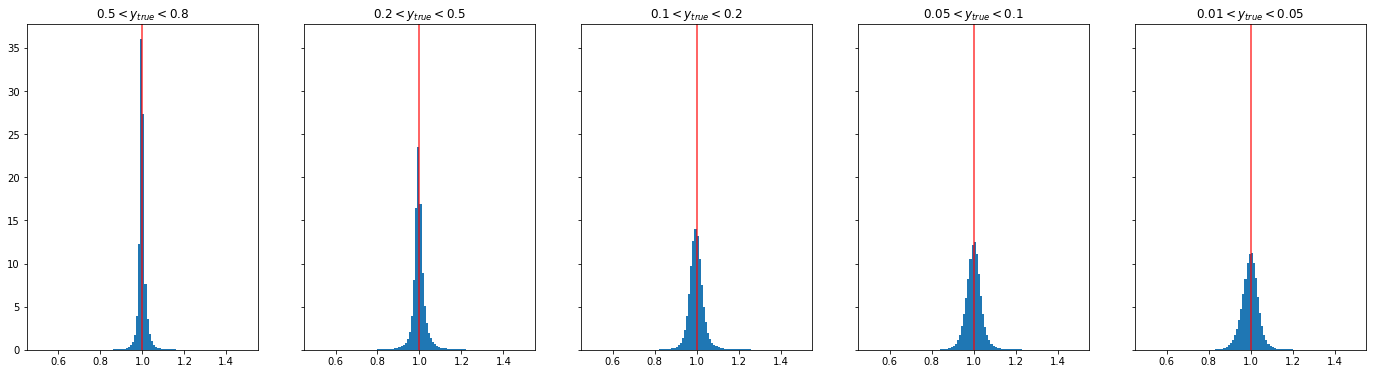

In [58]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

xmin = 0.5
xmax = 1.5

ax[0].hist(pred_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1].hist(pred_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2].hist(pred_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3].hist(pred_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4].hist(pred_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))






ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Comparison plots of resolution for methods vs DNN


## resolution in x

   0,  0,  5 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  0,  5 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  0,  5 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  0,  5 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  0,  5 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  1,  4 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  1,  4 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  1,  4 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  1,  4 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  1,  4 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  2,  3 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  2,  3 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  2,  3 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  2,  3 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  2,  3 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  3,  0 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  3,  0 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.

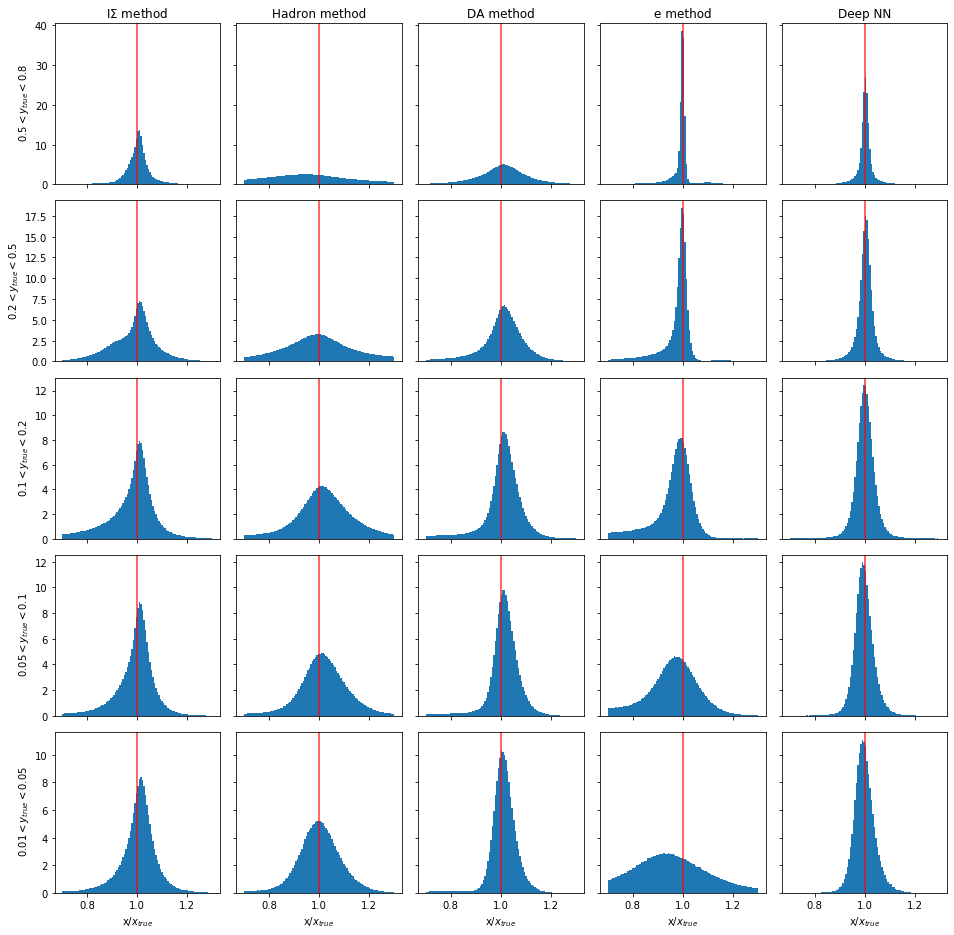

In [59]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)

methods_to_use = [5, 4, 3, 0]

xmin = 0.7
xmax = 1.3

#xmin = 0.5
#xmax = 1.5

y_cut = [
    'from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80',
    'from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50',
    'from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20',
    'from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10',
    'from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05',
]

for i in range(4):
    mi = methods_to_use[i]
    for yi in range( len(y_cut) ):
        print( '  %2d, %2d, %2d : %s' % (yi, i, mi, y_cut[yi]))
        ax[yi][i].hist( pandas_df.query(y_cut[yi])['obs_x[%d]' % mi ]/pandas_df.query(y_cut[yi])['from_tlv_gen_x'], 
                       density=True, bins=100, range=(xmin, xmax))

ax[0][4].hist(pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1][4].hist(pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2][4].hist(pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3][4].hist(pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4][4].hist(pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))


        
        
        
ax[0][0].set_title('I$\Sigma$ method')
ax[0][1].set_title('Hadron method')
ax[0][2].set_title('DA method')
ax[0][3].set_title('e method')
ax[0][4].set_title('Deep NN')
    
ax[0][0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[1][0].set_ylabel(' $0.2<y_{true}<0.5$')
ax[2][0].set_ylabel(' $0.1<y_{true}<0.2$')
ax[3][0].set_ylabel(' $0.05<y_{true}<0.1$')
ax[4][0].set_ylabel(' $0.01<y_{true}<0.05$')

ax[4][0].set_xlabel('x/$x_{true}$')
ax[4][1].set_xlabel('x/$x_{true}$')
ax[4][2].set_xlabel('x/$x_{true}$')
ax[4][3].set_xlabel('x/$x_{true}$')
ax[4][4].set_xlabel('x/$x_{true}$')

for i in range(5):
    for j in range(5):
        ax[i][j].axvline(1.0,color='red',lw=2,alpha=0.6)
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)


## resolution in Q2

   0,  0,  5 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  0,  5 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  0,  5 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  0,  5 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  0,  5 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  1,  4 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  1,  4 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  1,  4 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  1,  4 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  1,  4 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  2,  3 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  2,  3 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  2,  3 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  2,  3 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  2,  3 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  3,  0 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  3,  0 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.

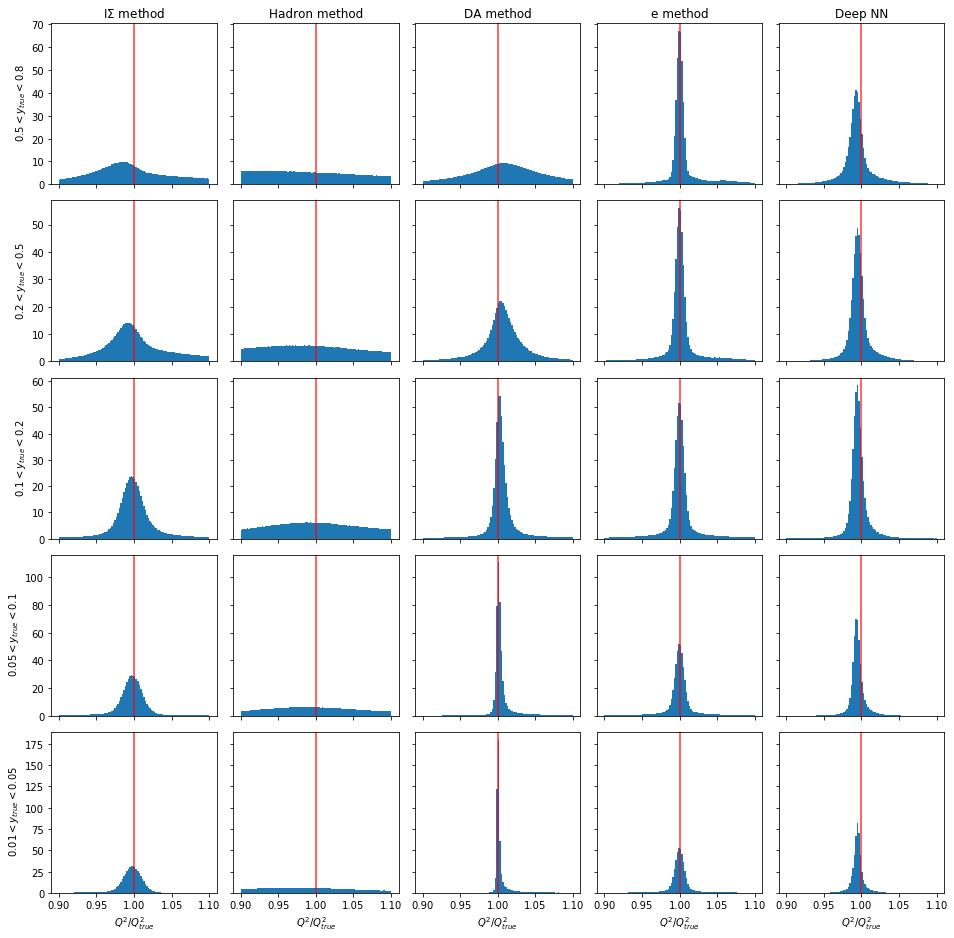

In [60]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)

methods_to_use = [5, 4, 3, 0]

nn_output_index = 1

xmin = 0.90
xmax = 1.10

#xmin = 0.5
#xmax = 1.5

y_cut = [
    'from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80',
    'from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50',
    'from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20',
    'from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10',
    'from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05',
]

for i in range(4):
    mi = methods_to_use[i]
    for yi in range( len(y_cut) ):
        print( '  %2d, %2d, %2d : %s' % (yi, i, mi, y_cut[yi]))
        ax[yi][i].hist( pandas_df.query(y_cut[yi])['obs_Q2[%d]' % mi ]/pandas_df.query(y_cut[yi])['from_tlv_gen_Q2'], 
                       density=True, bins=100, range=(xmin, xmax))

ax[0][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,nn_output_index][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,nn_output_index][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,nn_output_index][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,nn_output_index][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,nn_output_index][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))


        
        
        
ax[0][0].set_title('I$\Sigma$ method')
ax[0][1].set_title('Hadron method')
ax[0][2].set_title('DA method')
ax[0][3].set_title('e method')
ax[0][4].set_title('Deep NN')
    
ax[0][0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[1][0].set_ylabel(' $0.2<y_{true}<0.5$')
ax[2][0].set_ylabel(' $0.1<y_{true}<0.2$')
ax[3][0].set_ylabel(' $0.05<y_{true}<0.1$')
ax[4][0].set_ylabel(' $0.01<y_{true}<0.05$')

ax[4][0].set_xlabel('$Q^2/Q^2_{true}$')
ax[4][1].set_xlabel('$Q^2/Q^2_{true}$')
ax[4][2].set_xlabel('$Q^2/Q^2_{true}$')
ax[4][3].set_xlabel('$Q^2/Q^2_{true}$')
ax[4][4].set_xlabel('$Q^2/Q^2_{true}$')

for i in range(5):
    for j in range(5):
        ax[i][j].axvline(1.0,color='red',lw=2,alpha=0.6)
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)

## Resolution in y

   0,  0,  5 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  0,  5 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  0,  5 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  0,  5 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  0,  5 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  1,  4 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  1,  4 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  1,  4 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  1,  4 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  1,  4 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  2,  3 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  2,  3 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  2,  3 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  2,  3 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  2,  3 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  3,  0 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  3,  0 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.

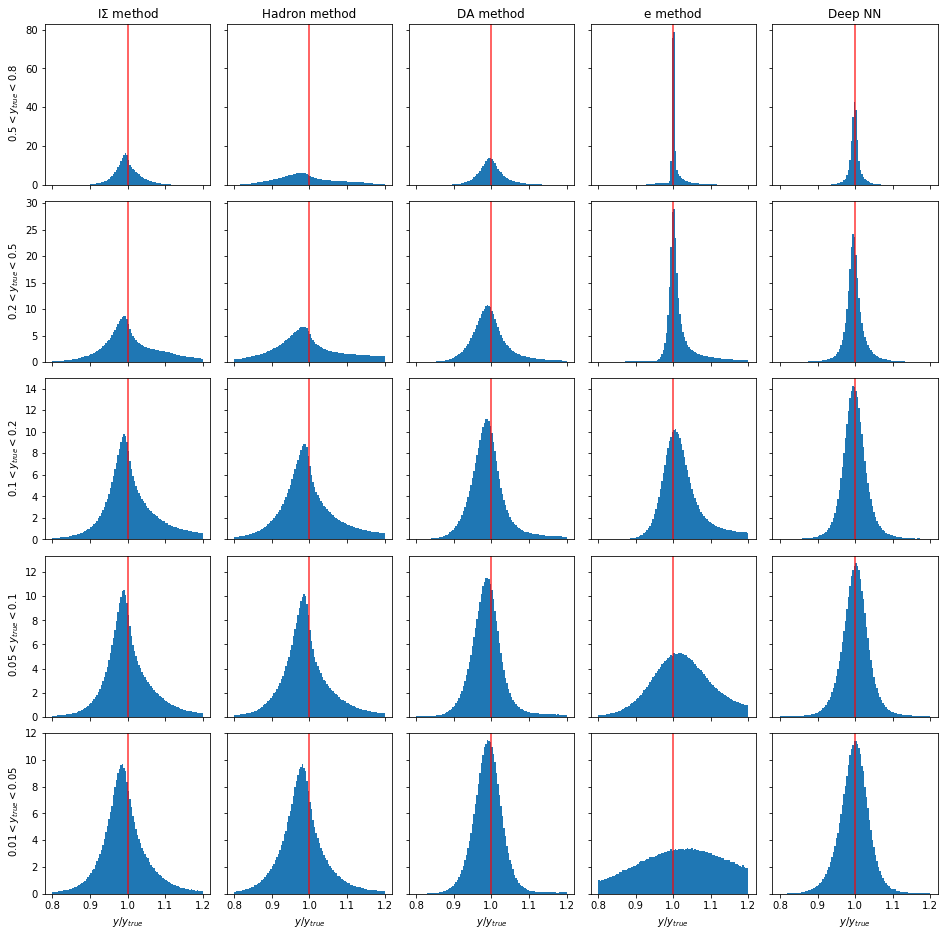

In [61]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)

methods_to_use = [5, 4, 3, 0]

nn_output_index = 2

#xmin = 0.90
#xmax = 1.10

xmin = 0.8
xmax = 1.2

y_cut = [
    'from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80',
    'from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50',
    'from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20',
    'from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10',
    'from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05',
]

for i in range(4):
    mi = methods_to_use[i]
    for yi in range( len(y_cut) ):
        print( '  %2d, %2d, %2d : %s' % (yi, i, mi, y_cut[yi]))
        ax[yi][i].hist( pandas_df.query(y_cut[yi])['obs_y[%d]' % mi ]/pandas_df.query(y_cut[yi])['from_tlv_gen_y'], 
                       density=True, bins=100, range=(xmin, xmax))

ax[0][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,nn_output_index][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,nn_output_index][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,nn_output_index][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,nn_output_index][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,nn_output_index][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))


        
        
        
ax[0][0].set_title('I$\Sigma$ method')
ax[0][1].set_title('Hadron method')
ax[0][2].set_title('DA method')
ax[0][3].set_title('e method')
ax[0][4].set_title('Deep NN')
    
ax[0][0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[1][0].set_ylabel(' $0.2<y_{true}<0.5$')
ax[2][0].set_ylabel(' $0.1<y_{true}<0.2$')
ax[3][0].set_ylabel(' $0.05<y_{true}<0.1$')
ax[4][0].set_ylabel(' $0.01<y_{true}<0.05$')

ax[4][0].set_xlabel('$y/y_{true}$')
ax[4][1].set_xlabel('$y/y_{true}$')
ax[4][2].set_xlabel('$y/y_{true}$')
ax[4][3].set_xlabel('$y/y_{true}$')
ax[4][4].set_xlabel('$y/y_{true}$')

for i in range(5):
    for j in range(5):
        ax[i][j].axvline(1.0,color='red',lw=2,alpha=0.6)
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)